# Dpi Setting

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


In [4]:
import os

print(os.getcwd())

/home/divar/projects/graphical-sampling/Simulations/Store


In [5]:
import os
os.chdir('/home/divar/projects/graphical-sampling')

### Dependencies

### Python

In [6]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [7]:
!apt-get install -y r-base
#!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [8]:
from rpy2.robjects.packages import importr

import numpy as np
from rpy2.robjects import numpy2ri, default_converter, globalenv
from rpy2.robjects.conversion import localconverter

/home/divar/projects/graphical-sampling/.venv/lib/python3.12/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:"
  warnings.warn(
/home/divar/projects/graphical-sampling/.venv/lib/python3.12/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:/usr/lib/jvm/java-17-openjdk-amd64/lib/server:", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-17-openjdk-amd64/l

In [9]:
%load_ext rpy2.ipython

### R

In [10]:
%%R

#library(spcosa)
#ibrary(spsurvey)
if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

Loading required package: WaveSampling
Loading required package: Matrix
Loading required package: sampling
Loading required package: BalancedSampling


### Imports

In [11]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#numpy2ri.activate()

rng = gs.random.rng()

/home/divar/projects/graphical-sampling/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

### Scores in R

In [12]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    with localconverter(default_converter + numpy2ri.converter):
      globalenv['sample_mask'] = sample_mask
      globalenv['sample_idx'] = sample_idx + 1  # Or int(sample_idx + 1) if it's just one value
      globalenv['coords'] = coords
      globalenv['probs'] = probs
      globalenv['n'] = n
      globalenv['N'] = N
    # ro.globalenv['sample_mask'] = sample_mask
    # ro.globalenv['sample_idx'] = sample_idx + 1
    # ro.globalenv['coords'] = coords
    # ro.globalenv['probs'] = probs
    # ro.globalenv['n'] = n
    # ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    print(sample_idx.reshape(1, -1))
    print(density_measure.score(sample_idx.reshape(1, -1)))
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[0][0], IB_value, SBLB_value
    # return scores[0][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

### Functions

In [13]:
autumn_cmap = plt.get_cmap('autumn')
plasma_cmap = plt.get_cmap('plasma')

def get_autumn_colors(n_clusters):
    """Returns n_clusters colors from the autumn colormap."""
    colors = autumn_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

def get_plasma_colors(n_clusters):
    """Returns n_clusters colors from the plasma colormap."""
    colors = plasma_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

# Example usage:
n = 10  # Number of clusters
n_clusters = n
import matplotlib.pyplot as plt
import numpy as np

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(mc.to_rgb(c))
    white = np.array([1, 1, 1])
    return tuple((1 - amount) * c + amount * white)

n_clusters = n
base_colors = plt.cm.plasma(np.linspace(0, 1, n_clusters))
light_colors = [lighten_color(col, 0.5) for col in base_colors]

autumn_colors = get_autumn_colors(n_clusters)
plasma_colors = get_plasma_colors(n_clusters)
plasma_colors = light_colors

In [14]:
def plot_convex_hull(points, ax, color, alpha=0.33, edge_color="gray", line_width=0.6):
    """Plot convex hull safely. Always returns (ax, hull or None)."""
    if len(points) < 3:
        return ax, None
    try:
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
            zorder=1
        )
        ax.add_patch(polygon)
        return ax, hull
    except QhullError:
        # Can't make hull, skip
        return ax, None


# Simulations

### Methods

In [15]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import default_converter, numpy2ri
from rpy2.robjects.conversion import localconverter

def local_pivotal_samples(coords, probs, n, num_samples):
    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        with localconverter(default_converter + numpy2ri.converter):
            ro.globalenv['coords'] = coords
            ro.globalenv['probs'] = probs
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method (BalancedSampling)
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones, sort_method):
    # Placeholder, replace with your actual method if necessary
    return gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=n_zones, sort_method=sort_method, tolerance=2, split_size=0.001).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    # Placeholder, replace with your implementation if available
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    with localconverter(default_converter + numpy2ri.converter):
        ro.globalenv['probs'] = probs
    n = int(round(np.sum(probs)))

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
mask <- UPmaxentropy(probs)
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

def wave_samples(coords, probs, n, num_samples):
    with localconverter(default_converter + numpy2ri.converter):
        ro.globalenv['coords'] = coords
        ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

def spcosa_samples(coords, n, num_samples):
    """
    Uses the spcosa R package for equal probability spatially balanced sampling.
    """
    with localconverter(default_converter + numpy2ri.converter):
        ro.globalenv['coords'] = coords
    N = coords.shape[0]
    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = f"""
library(spcosa)
set.seed({np.random.randint(1, 1e8)})
df <- data.frame(x = coords[,1], y = coords[,2])
coordinates(df) <- ~x + y
gridded(df) <- TRUE
stratification <- stratify(df, nStrata = {n}, nTry = 50)
samples <- spsample(stratification)
# Extract row indices in original data
whichrow <- as.integer(rownames(as(samples, "data.frame")))
"""
        ro.r(r_code)
        with localconverter(default_converter + numpy2ri.converter):
            sample_idx = np.array(ro.r("whichrow")) - 1  # zero-based for Python
        samples_idx[i] = sample_idx
    return samples_idx

def find_samples(coords, probs, n, num_samples, ep_mode="auto"):
    """
    Returns a dict of various sampling methods. 
    If ep_mode=="auto", heuristically deduce EP/UP from probs.
    """
    # Determine if this is the EP case: uniform probs and sum ~ n
    result = {
        "K-Means (11_lexico)": k_means_samples(coords, probs, n, num_samples, (1, 1), sort_method="lexico"),
        "K-Means (11_random)": k_means_samples(coords, probs, n, num_samples, (1, 1), sort_method="random"),
        # "K-Means (12_lexico)": k_means_samples(coords, probs, n, num_samples, (1, 2), sort_method="lexico"),
        # "K-Means (12_random)": k_means_samples(coords, probs, n, num_samples, (1, 2), sort_method="random"),
        # "K-Means (22_lexico)": k_means_samples(coords, probs, n, num_samples, (2, 2), sort_method="lexico"),
        # "K-Means (22_random)": k_means_samples(coords, probs, n, num_samples, (2, 2), sort_method="random"),
        # "K-Means (23_lexico)": k_means_samples(coords, probs, n, num_samples, (2, 3), sort_method="lexico"),
        # "K-Means (23_random)": k_means_samples(coords, probs, n, num_samples, (2, 3), sort_method="random"),
        "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        "Random": random_samples(coords, probs, n, num_samples),
        "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        "Wave": wave_samples(coords, probs, n, num_samples),
    }
    return result

### river plot

In [16]:
%%R
library(sf)
library(sp)

# load meuse river data
data(meuse.riv)

# convert to sf object
meuse_sf <- st_sfc(st_linestring(meuse.riv), crs = 28992)

# save as shapefile
st_write(meuse_sf, "meuse_river.shp", delete_layer=TRUE)


Deleting layer `meuse_river' using driver `ESRI Shapefile'
Writing layer `meuse_river' to data source 
  `meuse_river.shp' using driver `ESRI Shapefile'
Writing 1 features with 0 fields and geometry type Line String.


Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.4.0; sf_use_s2() is TRUE


In [17]:
import numpy as np
import pandas as pd

# --- SEEDING for reproducibility ---
np.random.seed(42)

# --- PARAMS ---
n = 4 # Target sample size
meuse_csv = '/home/divar/projects/graphical-sampling/Simulations/meuse.csv'

# --- Function placeholders (must define elsewhere in your codebase!) ---
# rng.equal_probabilities(n, N)
# inclusion_probabilities(area, n)
# gs.sampling.KMeansSpatialSamplingSimple  # for pop objects

# --- 1. Setup holders for all coordinates/probs/populations ---
populations = {}
probabilities = {}
pop_objs = {}

# --- 2. MEUSE: Load, extract coords, setup probabilities ---
meuse_df = pd.read_csv(meuse_csv)
# Extract original x/y for clarity
#meuse_df['x'] = round(meuse_df['x']/10000)
#meuse_df['y'] = round(meuse_df['y']/10000)
coords_meuse = meuse_df[['x', 'y']].to_numpy()
N_meuse = coords_meuse.shape[0]
area = meuse_df['copper'].clip(1, 150)

# Assumes rng and inclusion_probabilities are defined in your environment
probs_meuse_eq = rng.equal_probabilities(n, N_meuse)
probs_meuse_uneq = inclusion_probabilities(area, n)

populations['meuse'] = coords_meuse
probabilities['meuse_eq'] = probs_meuse_eq
probabilities['meuse_uneq'] = probs_meuse_uneq

# --- 3. Create population objects based on meuse data only ---
hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_meuse, probs_meuse_eq, n=n, n_zones=(2, 3), tolerance=3, split_size=0.001)
pop_objs['meuse_eq'] = hard.popu

hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_meuse, probs_meuse_uneq, n=n, n_zones=(2, 3), tolerance=3, split_size=0.001)
pop_objs['meuse_uneq'] = hard.popu

# Now,
# - 'populations' dict holds coordinates
# - 'probabilities' dict holds both eq/uneq probabilities
# - 'pop_objs' dict holds population objects constructed with these

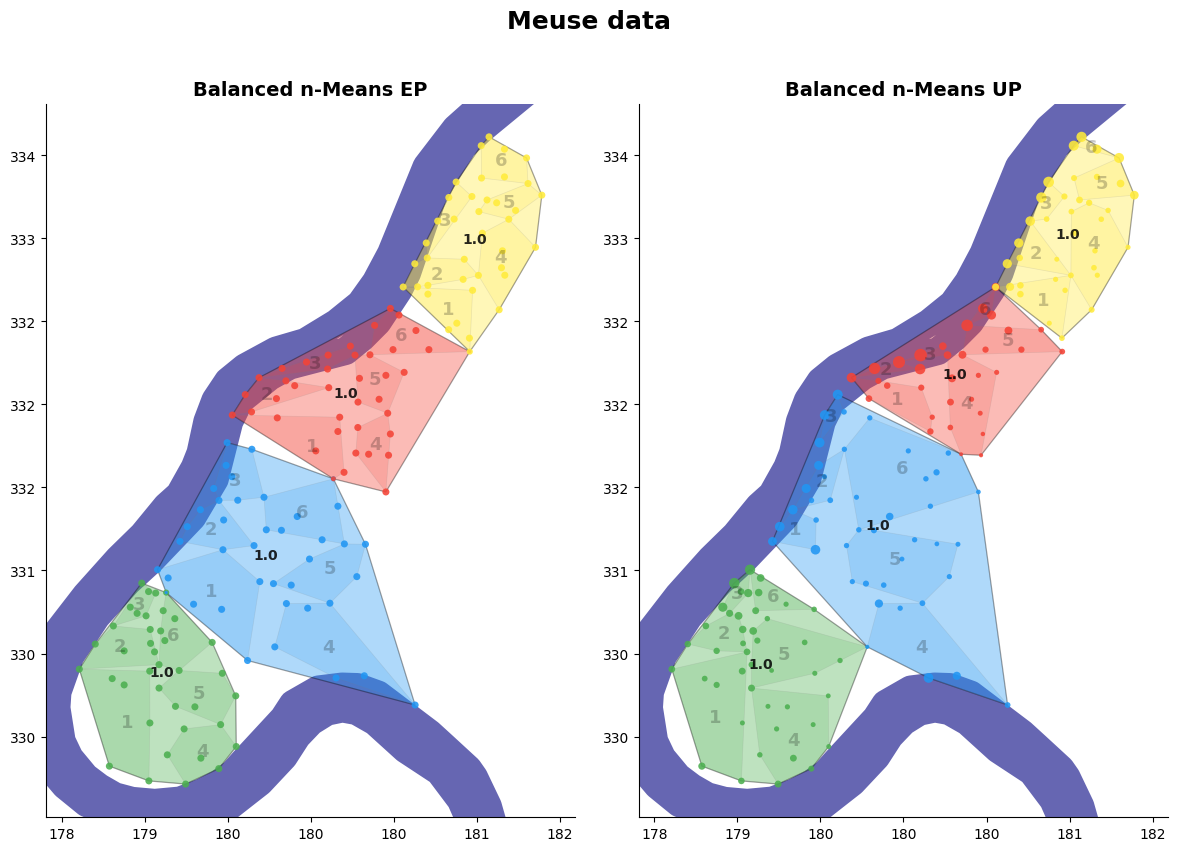

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull, QhullError
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from matplotlib.ticker import FuncFormatter

# ---- COLOURS ----
bardi_colors = [
    "#F44336", "#4CAF50", "#FFEB3B", "#9C27B0",
    "#FF9800", "#9C27B0", "#E91E63", "#00BCD4",
    "#BDBDBD", "#FFD700"
]
row_labels = [
    "Balanced n-Means EP",
    "Balanced n-Means UP",
    "Size Balanced Clustering UP",
    "K-Means Clustering UP",
]

# ---- FUNCTIONS ----
def get_sorted_cluster_indices_by_lexico_centroids(centroids):
    sorted_order = np.lexsort((centroids[:, 0], centroids[:, 1]))
    label_to_color = np.zeros_like(sorted_order)
    for color_idx, label in enumerate(sorted_order):
        label_to_color[label] = color_idx
    return label_to_color, centroids[sorted_order]

def plot_convex_hull(points, ax, color, alpha=0.33, edge_color="gray", line_width=0.6):
    if len(points) < 3:
        return ax, None
    try:
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
            zorder=1
        )
        ax.add_patch(polygon)
        return ax, hull
    except QhullError:
        return ax, None


# ---- READ MEUSE RIVER ----
river = gpd.read_file("/home/divar/projects/graphical-sampling/meuse_river.shp")

# Ensure CRS matches your data
river = river.to_crs(epsg=28992)

# ---- SCALING ----
SCALING = 1  # adjust if needed
coords_eq = pop_objs['meuse_eq'].coords / SCALING
probs_eq = pop_objs['meuse_eq'].probs

coords_uneq = pop_objs['meuse_uneq'].coords / SCALING
probs_uneq = pop_objs['meuse_uneq'].probs

n_clusters = n
colors = bardi_colors[:n_clusters]

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle("Meuse data", fontsize=18, fontweight='bold', y=1.03)
axes = axes.flatten()

# -- Balanced n-Means EP --
river_color = 'navy'  # Define the river color
river_width = 20  # Define the river width
ax = axes[0]
river.plot(ax=ax, color=river_color, linewidth=river_width, alpha=0.6, zorder=0)
pop_objs['meuse_eq'].plot(ax=ax)
ax.set_title(row_labels[0], fontsize=14, fontweight='bold')

# -- Balanced n-Means UP --
ax = axes[1]
river.plot(ax=ax, color=river_color, linewidth=river_width, alpha=0.6, zorder=0)
pop_objs['meuse_uneq'].plot(ax=ax)
ax.set_title(row_labels[1], fontsize=14, fontweight='bold')

# Define the focused area based on data
x_min, y_min = np.min(coords_eq, axis=0) - 200
x_max, y_max = np.max(coords_eq, axis=0) + 200
def rescale_ticks(x, pos):
    return f"{x / 1000:.0f}"
formatter = FuncFormatter(rescale_ticks)

for ax in axes:
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect("equal")
    ax.autoscale(False)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


In [19]:
import numpy as np
import pandas as pd

# --- SEEDING for reproducibility ---
np.random.seed(42)

# --- PARAMS ---
# Target sample size
meuse_csv = '/home/divar/projects/graphical-sampling/Simulations/meuse.csv'

# --- Function placeholders (must define elsewhere in your codebase!) ---
# rng.equal_probabilities(n, N)
# inclusion_probabilities(area, n)
# gs.sampling.KMeansSpatialSamplingSimple  # for pop objects

# --- 1. Setup holders for all coordinates/probs/populations ---
populations = {}
probabilities = {}
pop_objs = {}

# --- 2. MEUSE: Load, extract coords, setup probabilities ---
meuse_df = pd.read_csv(meuse_csv)
# Extract original x/y for clarity
xy = meuse_df[['x', 'y']]
scaled_xy = (xy - xy.min()) / (xy.max() - xy.min())
meuse_df[['x', 'y']] = scaled_xy
#meuse_df['x'] = round(meuse_df['x']/10000)
#meuse_df['y'] = round(meuse_df['y']/10000)
coords_meuse = meuse_df[['x', 'y']].to_numpy()
N_meuse = coords_meuse.shape[0]
# area = meuse_df['copper'].clip(1, 150)
area = meuse_df['copper'].clip(1, 150)
# Assumes rng and inclusion_probabilities are defined in your environment
probs_meuse_eq = rng.equal_probabilities(n, N_meuse)
probs_meuse_uneq = inclusion_probabilities(area, n)

populations['meuse'] = coords_meuse
probabilities['meuse_eq'] = probs_meuse_eq
probabilities['meuse_uneq'] = probs_meuse_uneq

# --- 3. Create population objects based on meuse data only ---
hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_meuse, probs_meuse_eq, n=n, n_zones=(2, 2), tolerance=3, split_size=0.001)
pop_objs['meuse_eq'] = hard.popu

hard = gs.sampling.KMeansSpatialSamplingSimple(
    coords_meuse, probs_meuse_uneq, n=n, n_zones=(2, 2), tolerance=3, split_size=0.001)
pop_objs['meuse_uneq'] = hard.popu



### Gathering Data

In [20]:
import pandas as pd
import os

folder = "data_samples/coords_probs"
os.makedirs(folder, exist_ok=True)

#   # diactivated to not overwrite some new results!
for name, pop in pop_objs.items():
    # Assuming pop.coords shape (N,2), pop.probs shape (N,)
    df = pd.DataFrame(pop.coords, columns=["x", "y"])
    df["prob"] = pop.probs
    filename = f"{name}.csv"
    df.to_csv(os.path.join(folder, filename), index=False)
    print(f"Saved {filename}")

Saved meuse_eq.csv
Saved meuse_uneq.csv


In [21]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
folder = "data_samples/results"
os.makedirs(folder, exist_ok=True)
all_coords = []
all_probs = []
names = [
    "meuse_eq", "meuse_uneq",]

for name in names:
    df = pd.read_csv(f"data_samples/coords_probs/{name}.csv")
    coords = df[["x", "y"]].values
    probs = df["prob"].values
    all_coords.append(coords)
    all_probs.append(probs)
print(sum(probs))
print(len(probs))
sample_cnt = 3
columns = ["Method", "Density", "Moran", "Local Balance"]

for coords, probs, name in zip(all_coords, all_probs, names):
    print(name)
    n = int(np.round(np.sum(probs)))
    N =len(probs)
    # Any code for one set, put here:
    sample_methods = find_samples(coords, probs, n, sample_cnt)
    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    rows = np.array([
    [method, *scores(coords, probs, n, N, s, density_measure)]
    for method, samples in sample_methods.items()
    if samples is not None  # <----- add this
    for s in tqdm(samples, total=sample_cnt)
])
    df = pd.DataFrame(rows, columns=columns)
    df = df.astype({
        "Density": float,
        #"Voronoi": float,
        "Moran": float,
        "Local Balance": float
    })
    filename = os.path.join(folder, f"initial_results_{name}.csv")
    df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

3.9999999999999916
155
meuse_eq


  0%|          | 0/3 [00:00<?, ?it/s]

[[ 99  23  56 136]]
[0.13189105]


  0%|          | 0/3 [00:02<?, ?it/s]


ValueError: not enough values to unpack (expected 2, got 1)

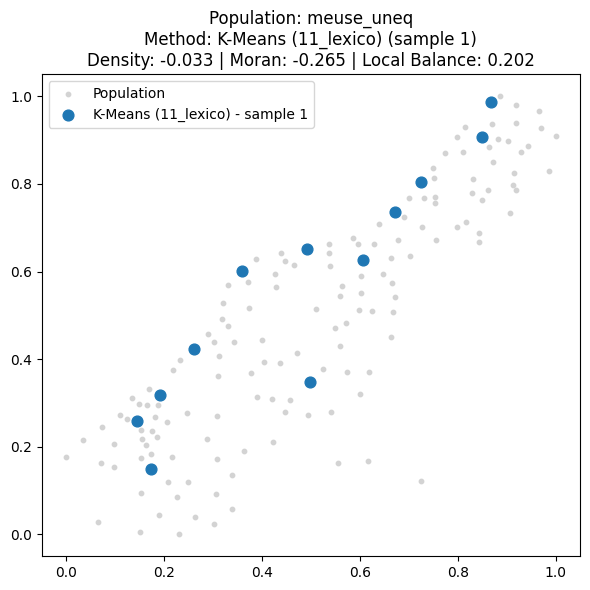

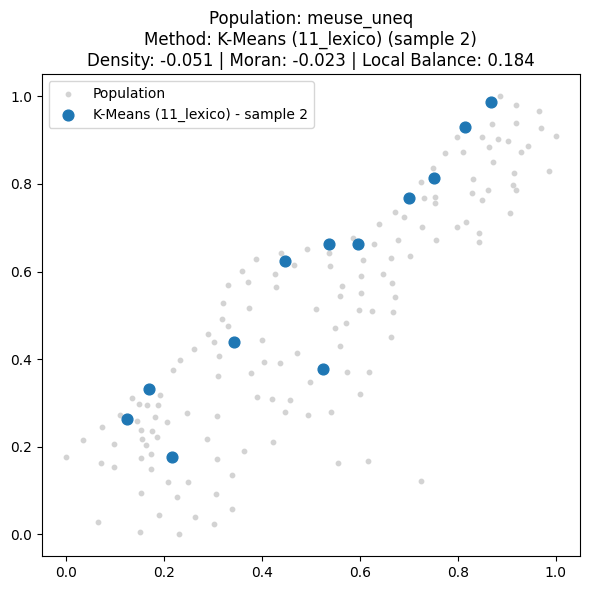

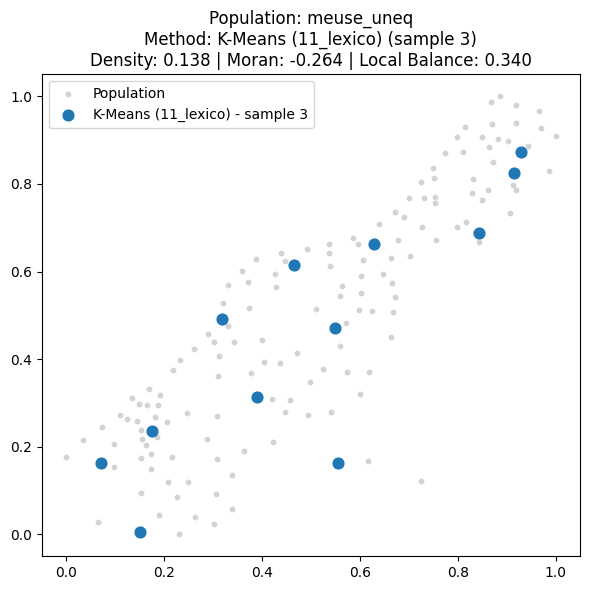

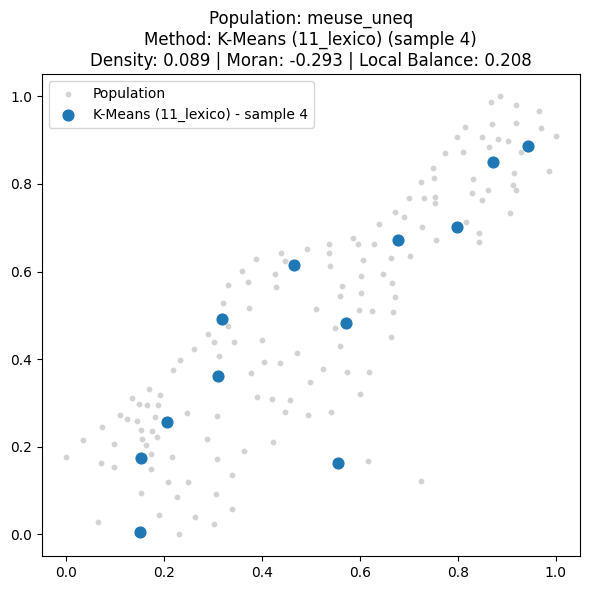

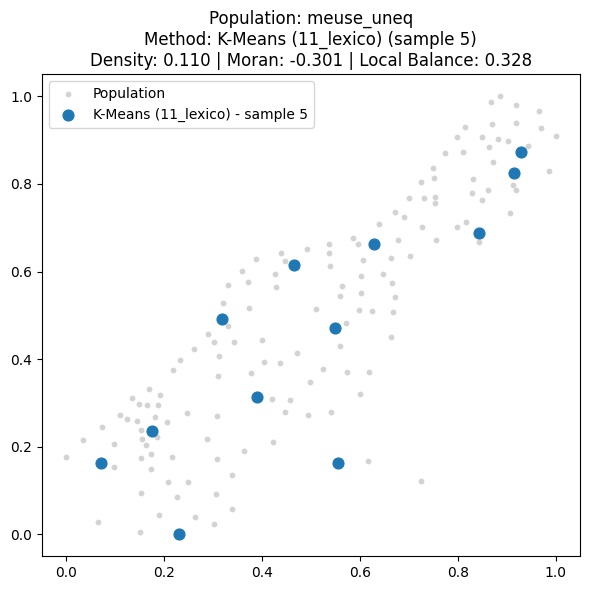

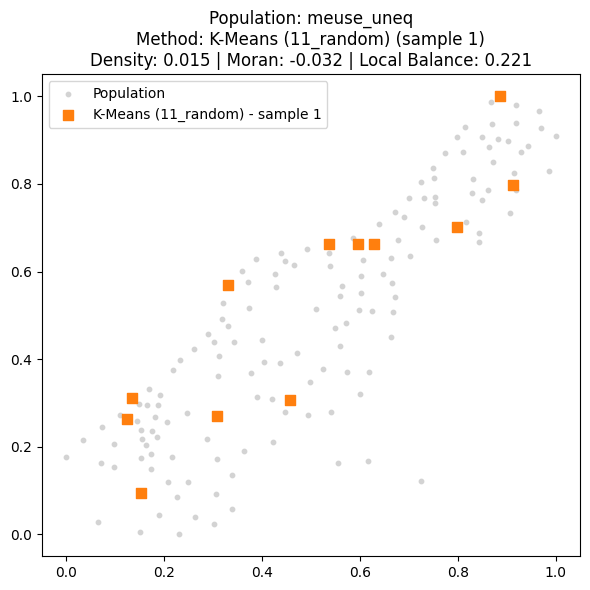

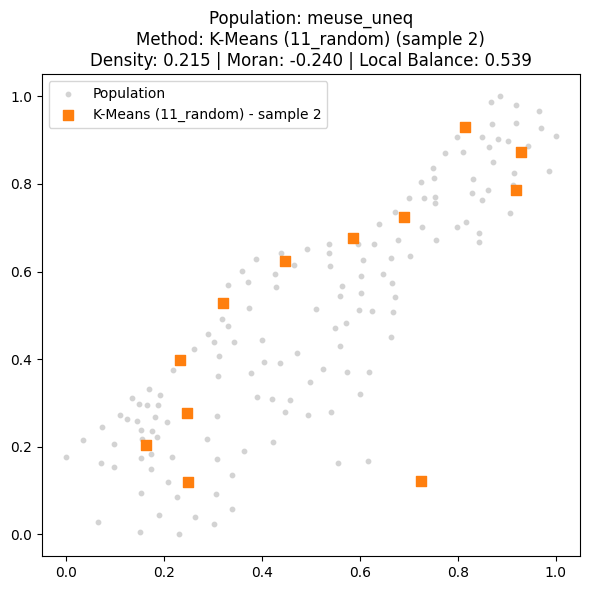

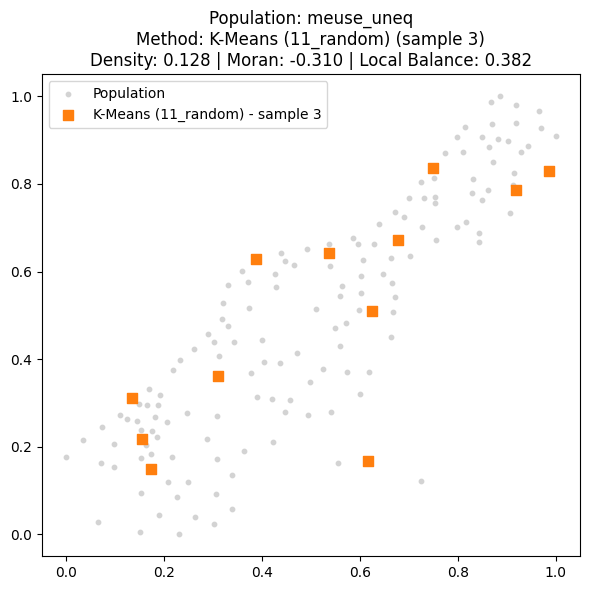

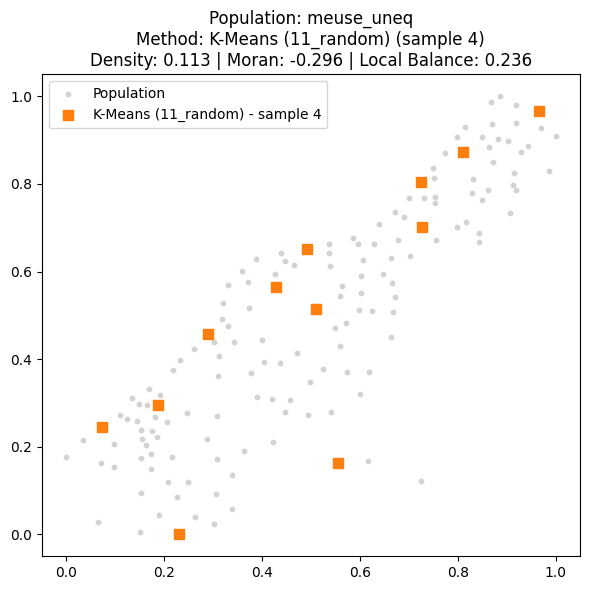

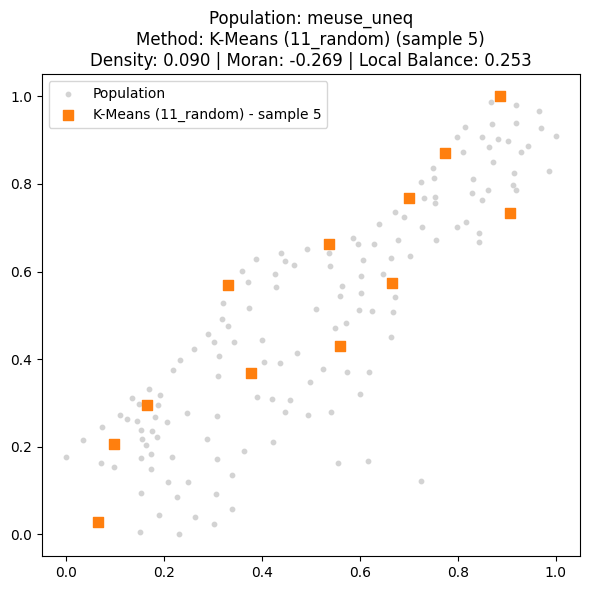

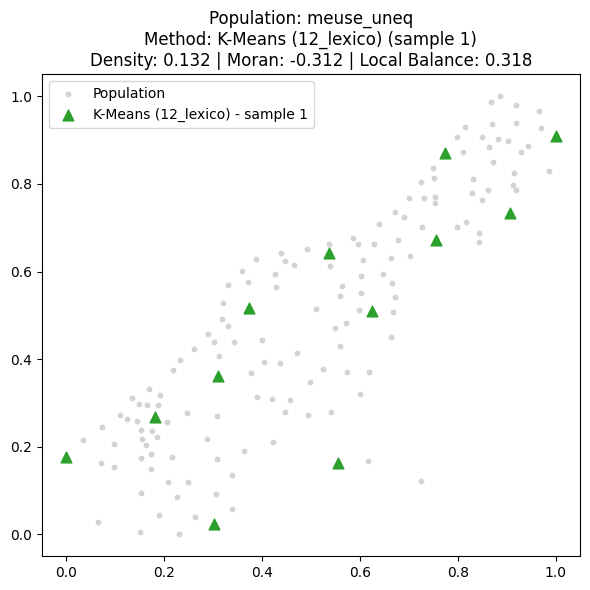

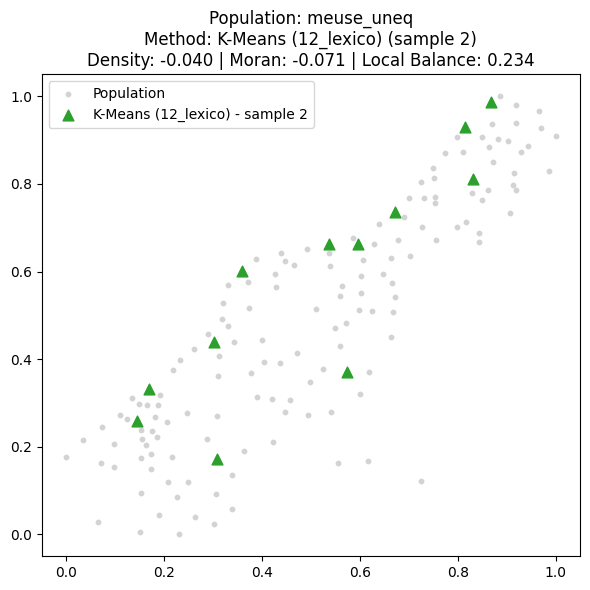

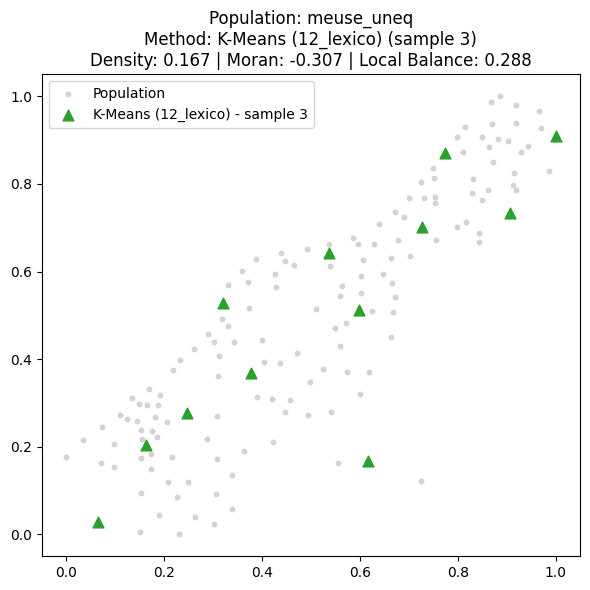

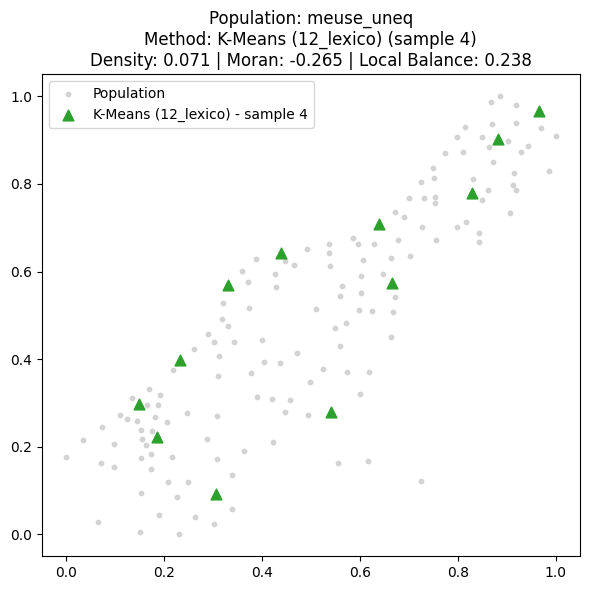

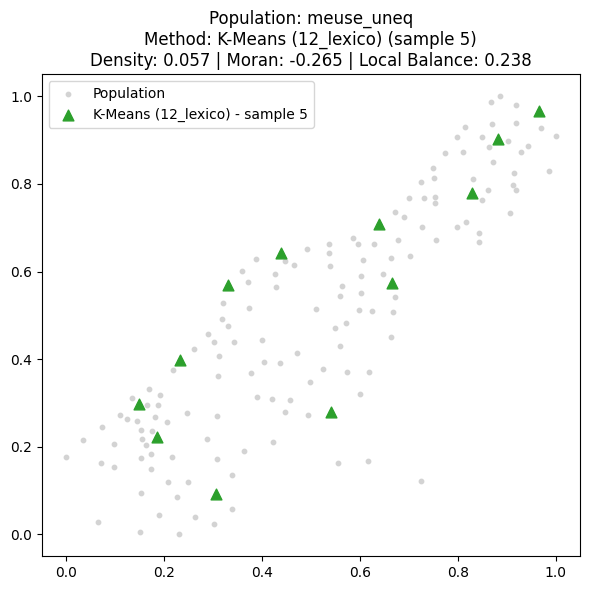

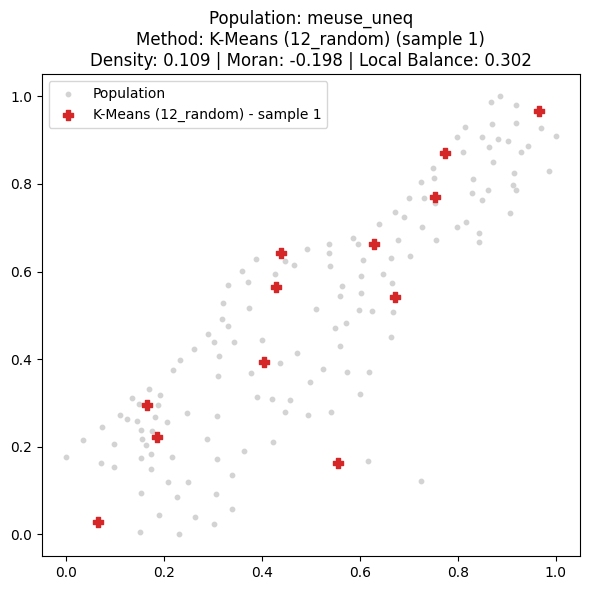

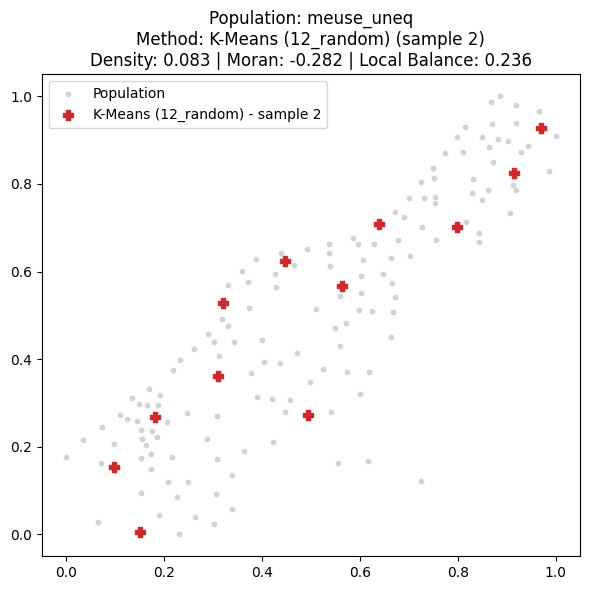

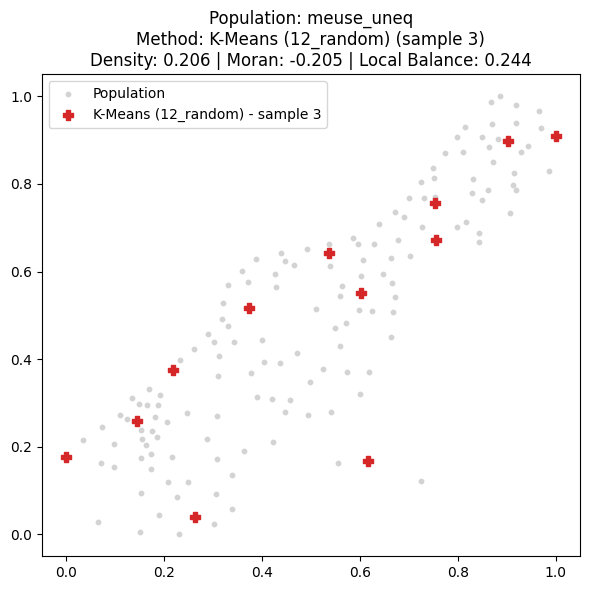

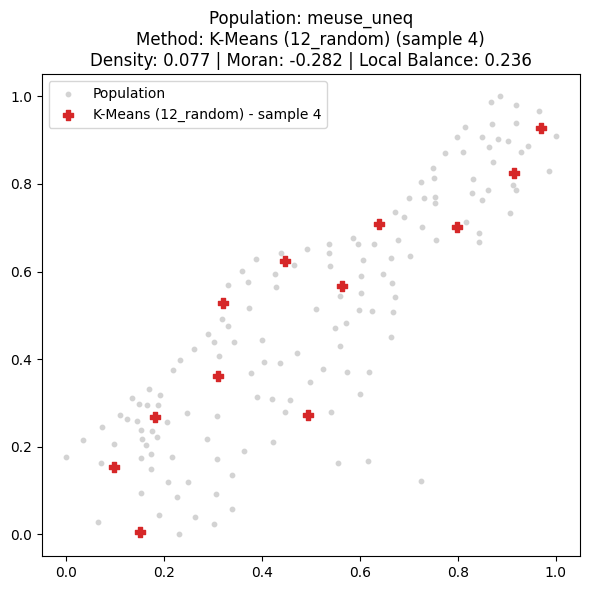

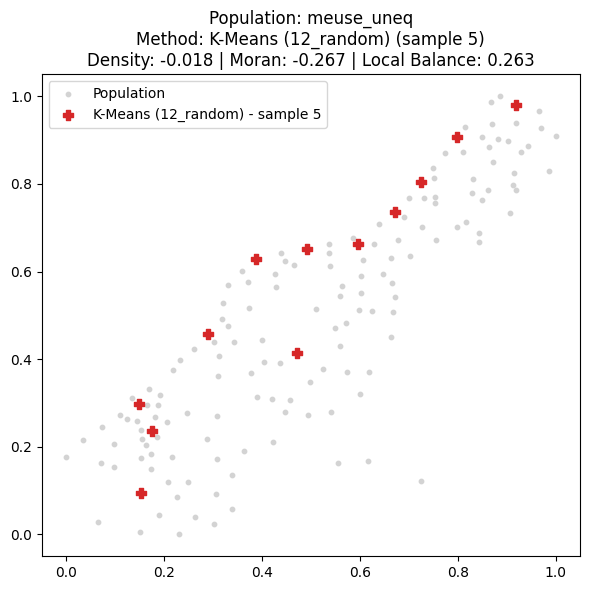

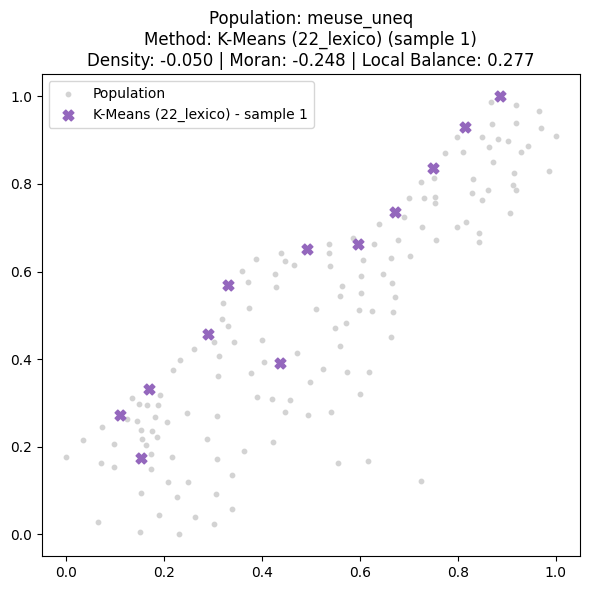

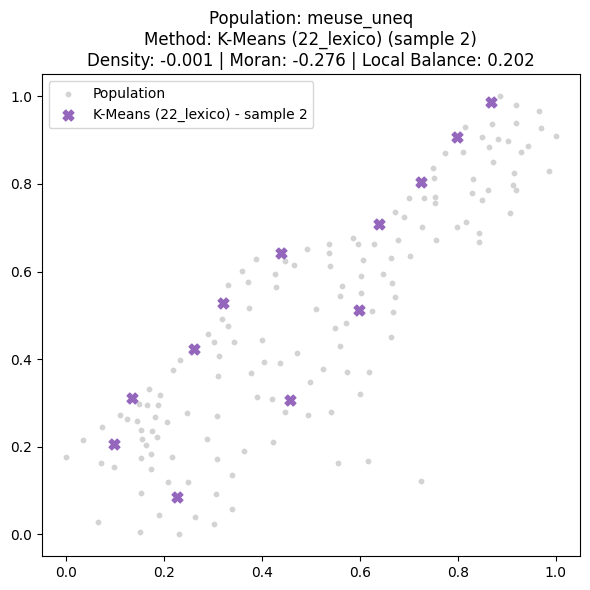

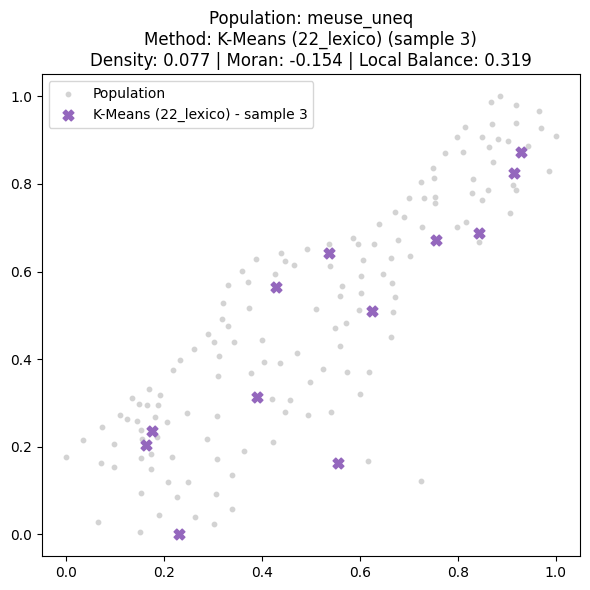

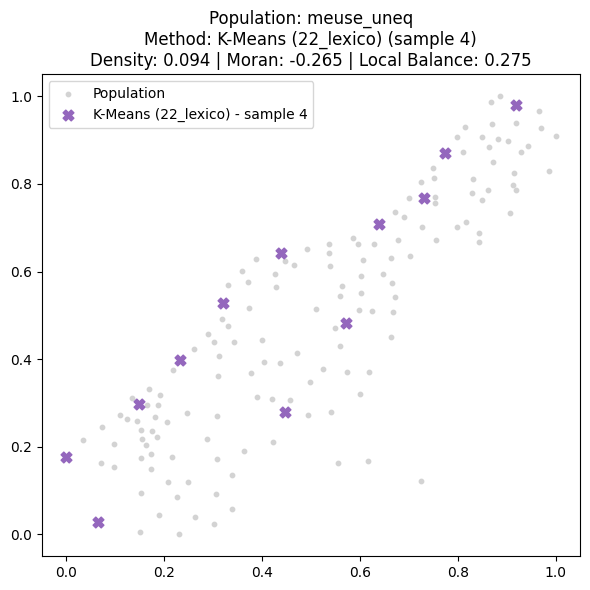

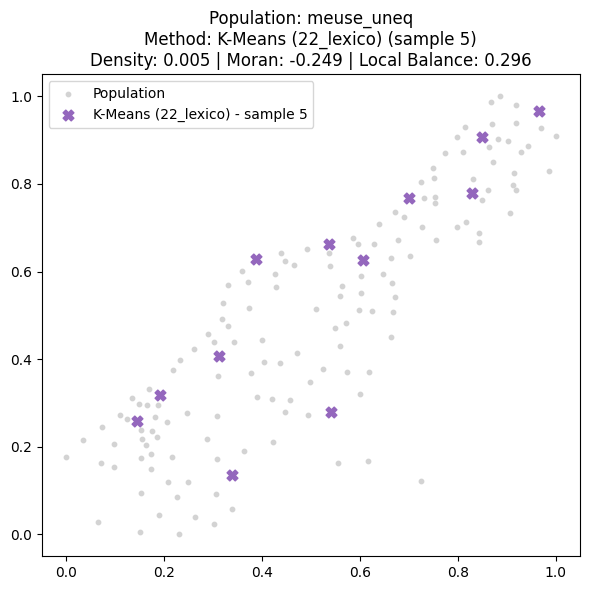

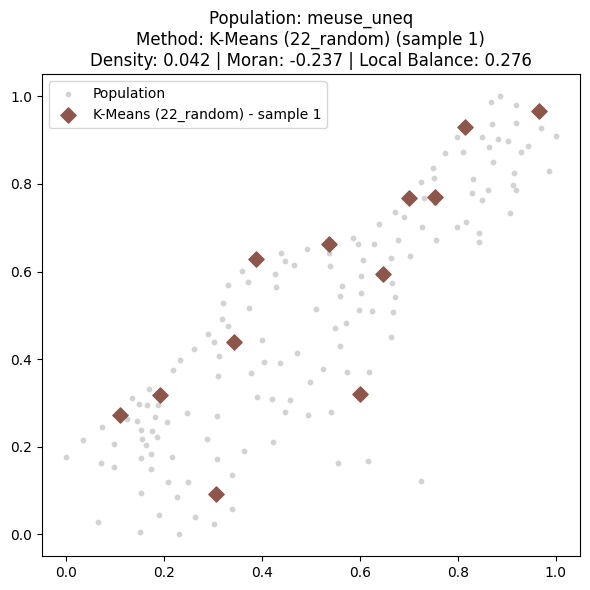

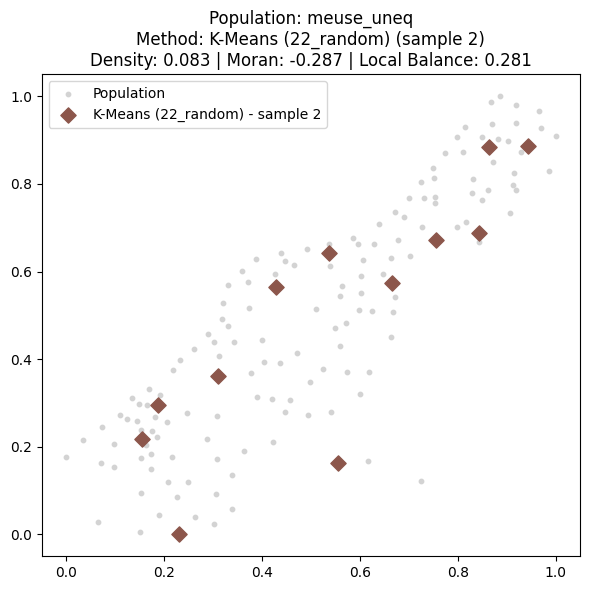

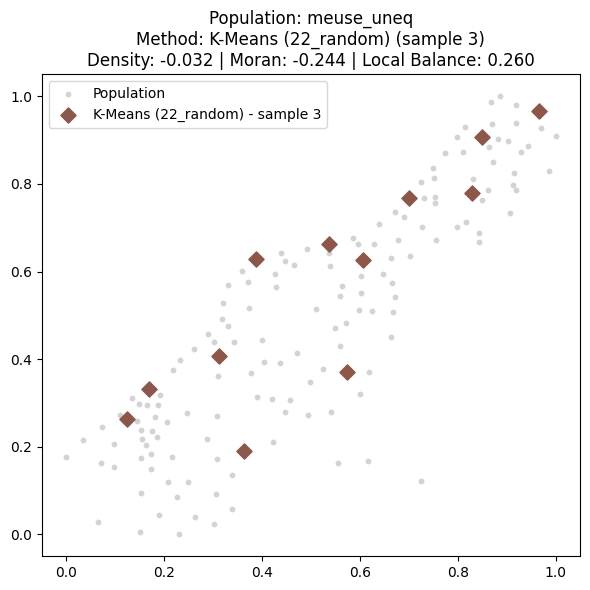

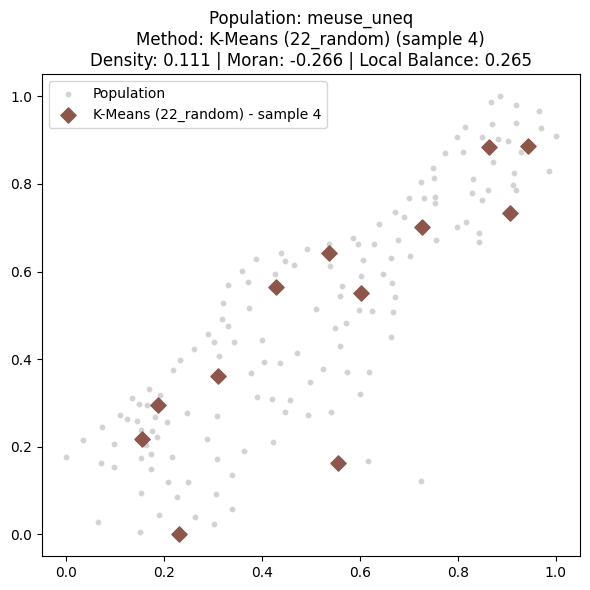

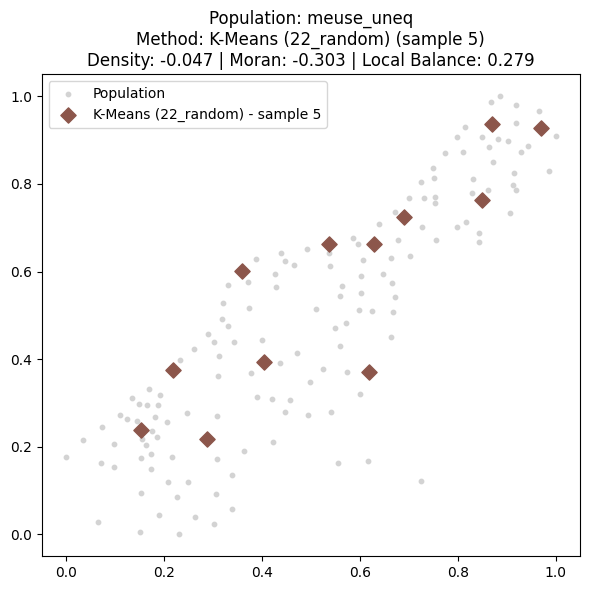

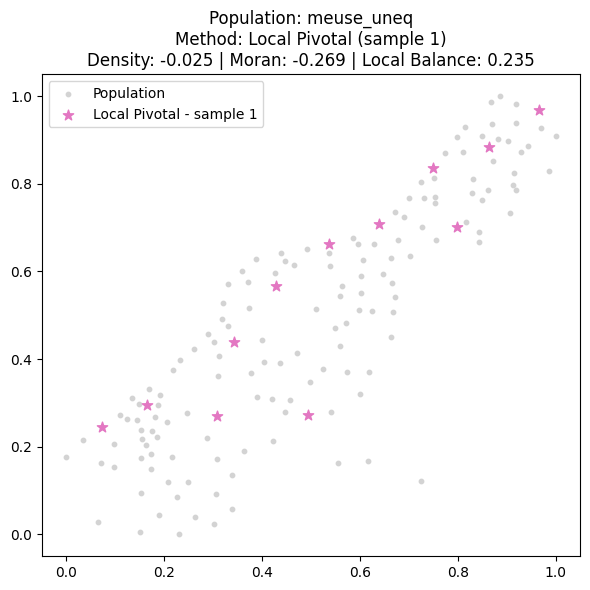

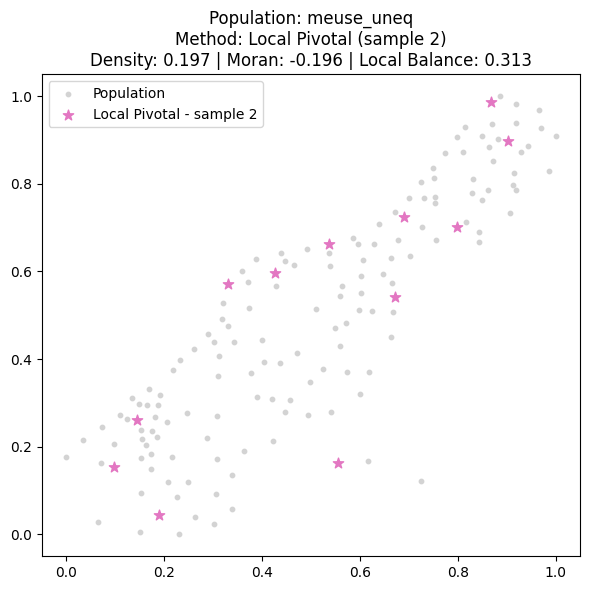

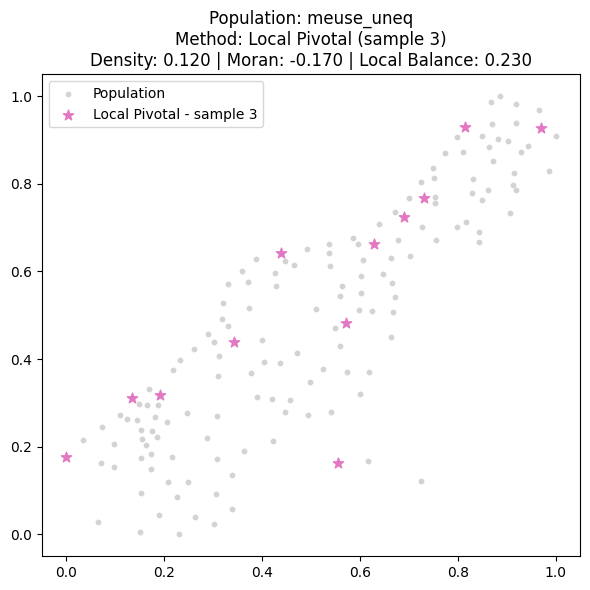

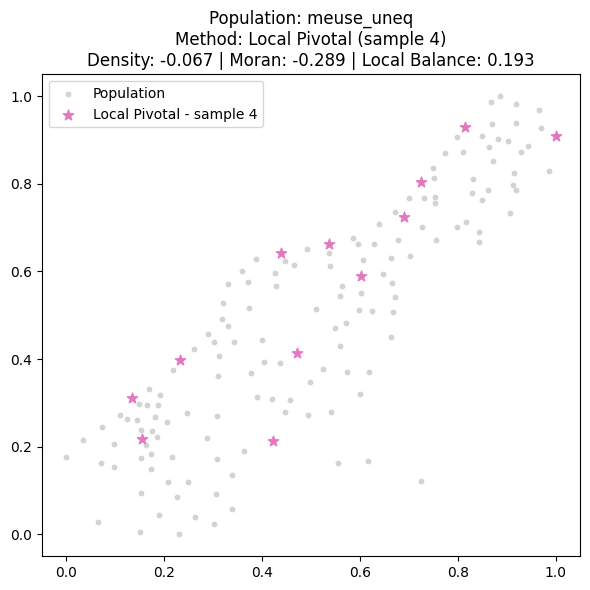

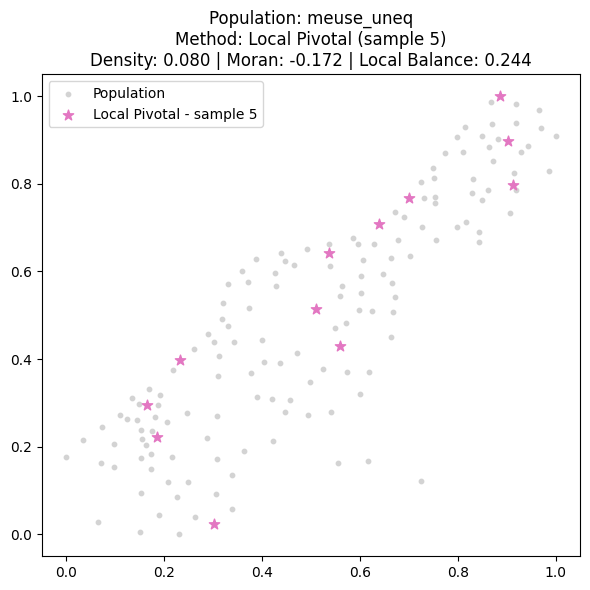

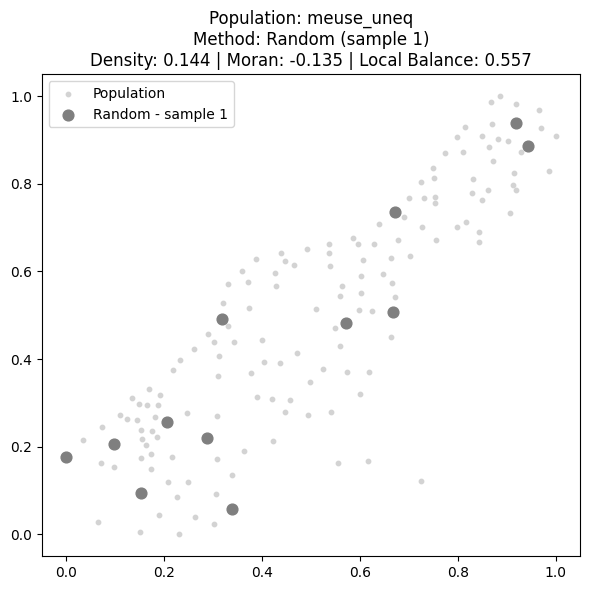

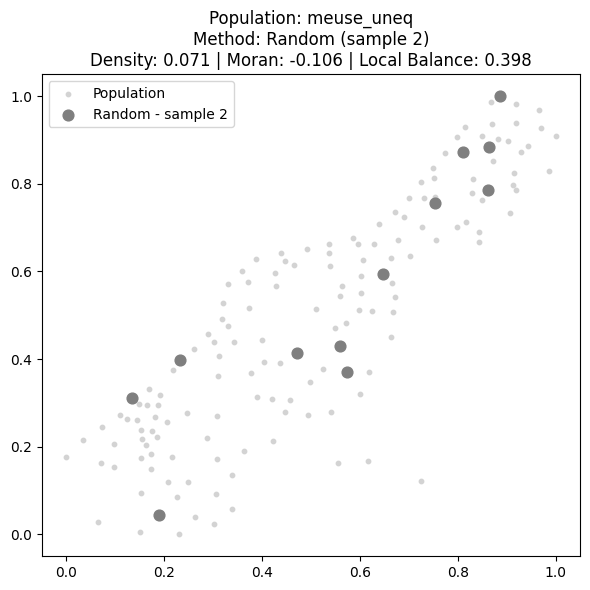

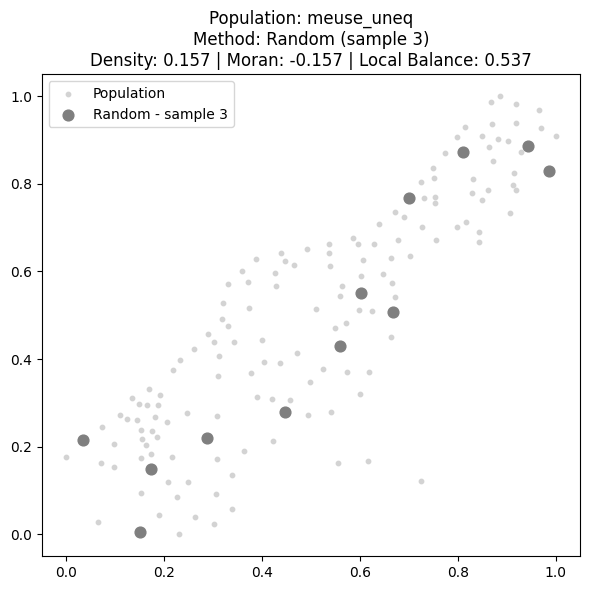

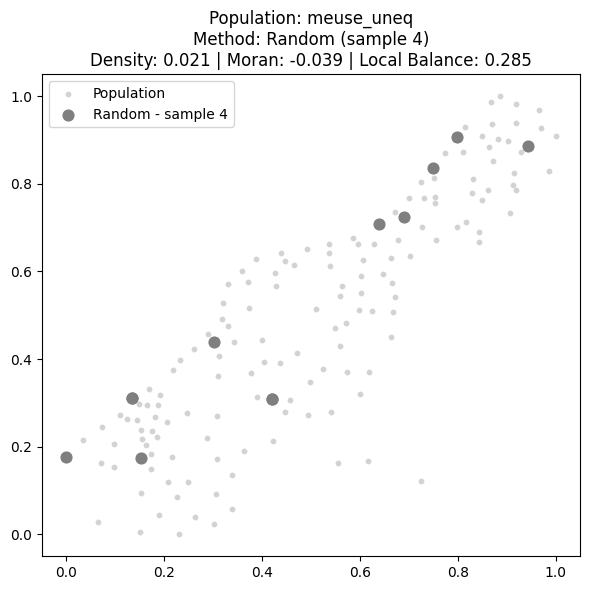

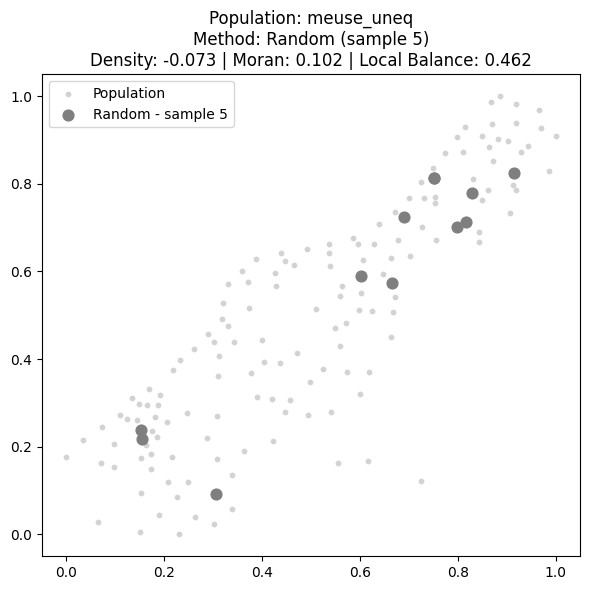

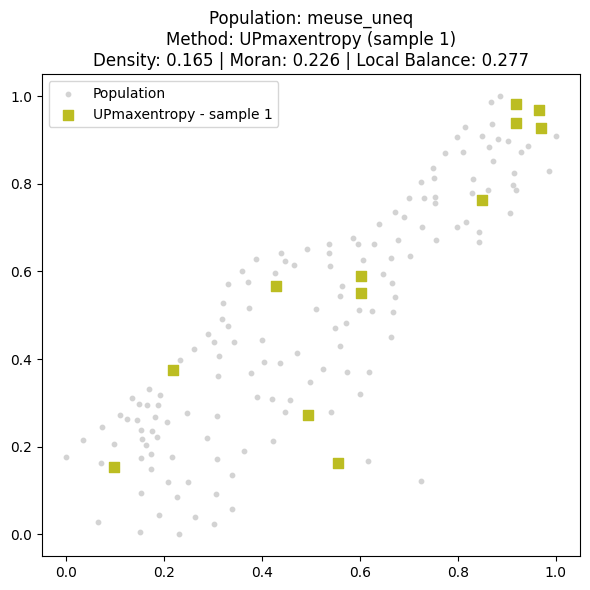

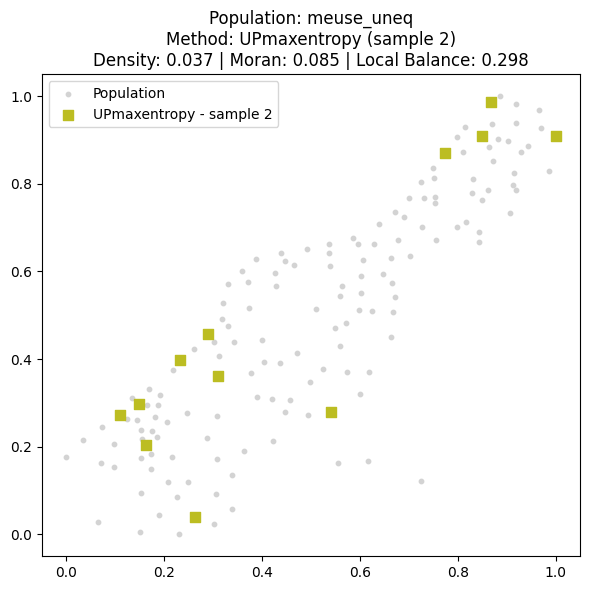

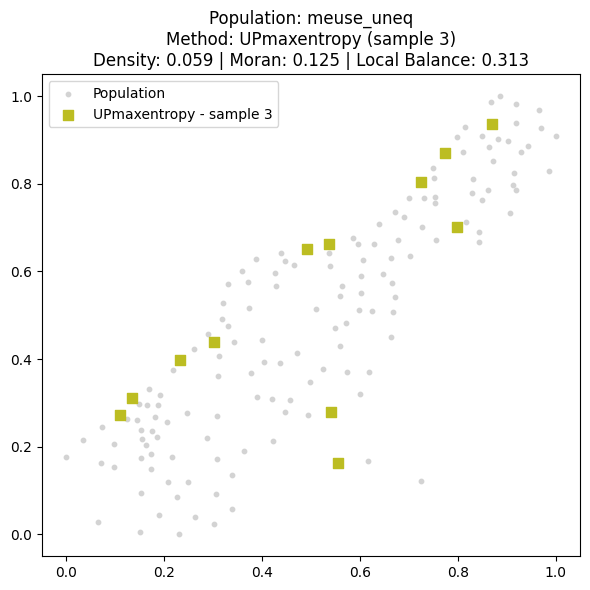

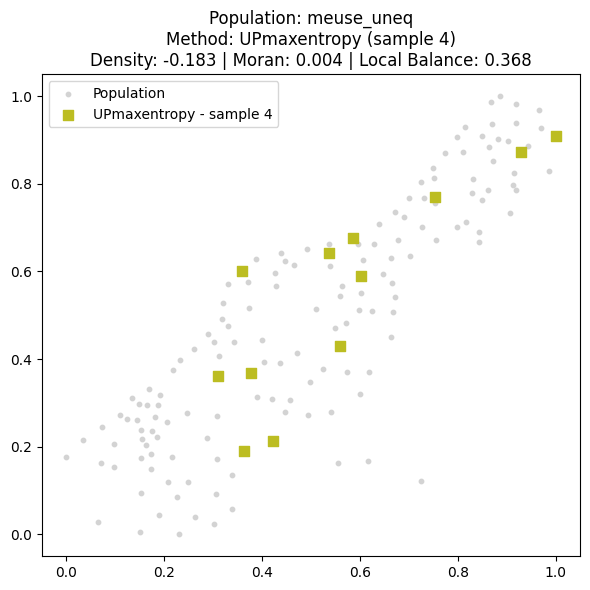

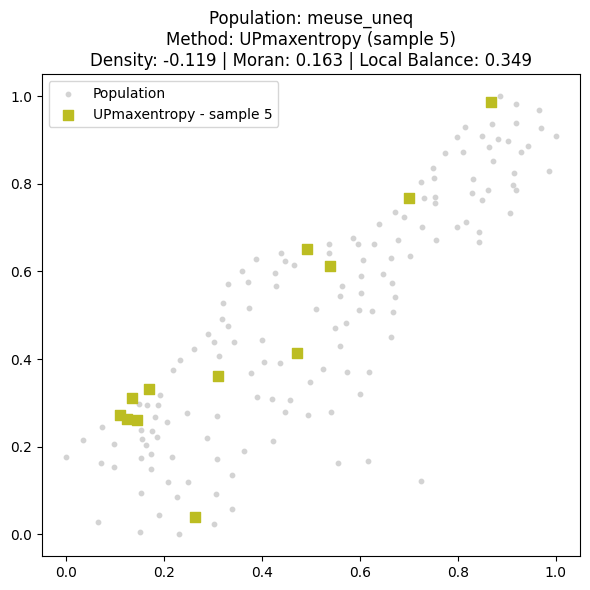

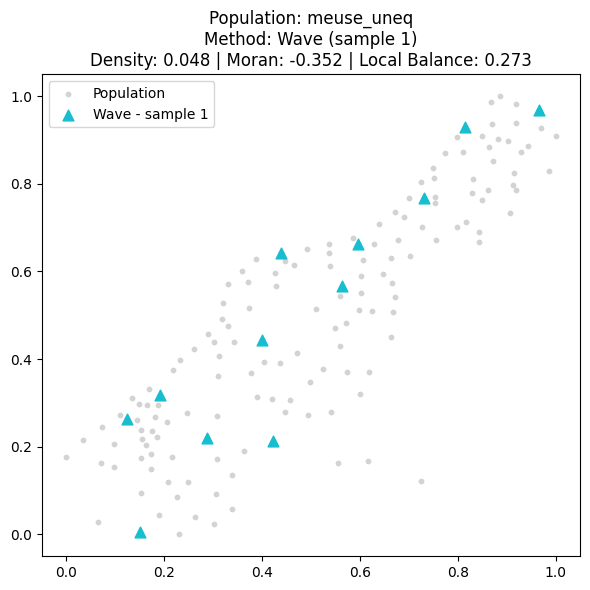

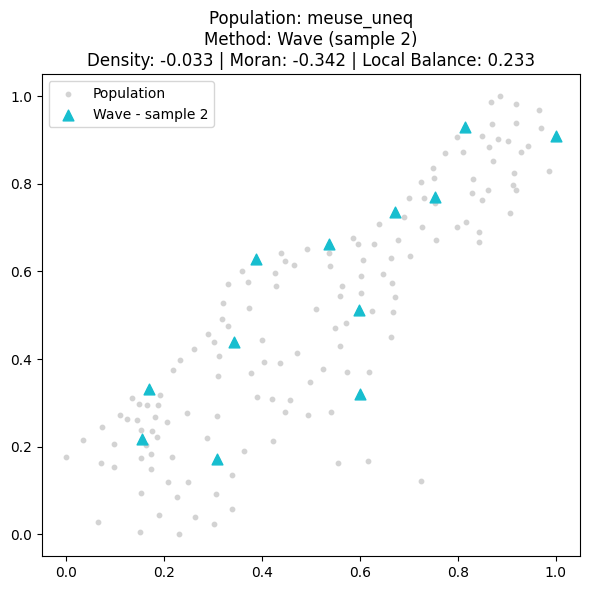

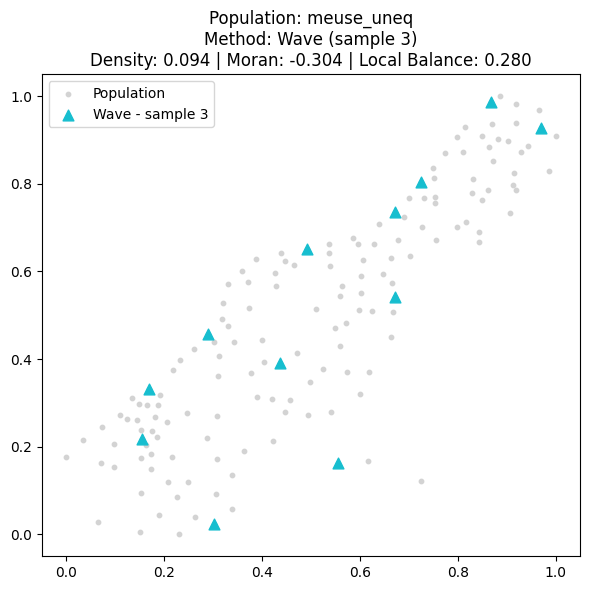

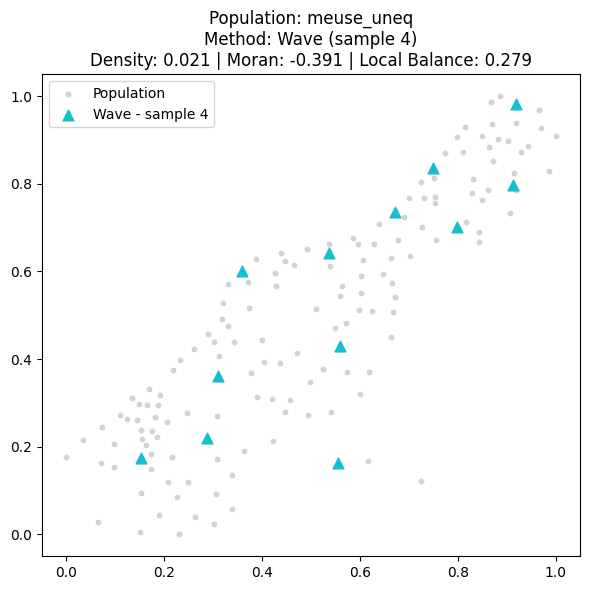

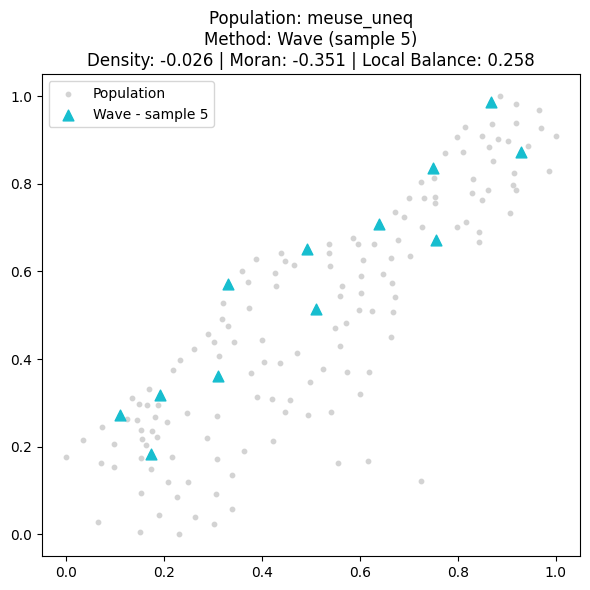

In [58]:
import matplotlib.pyplot as plt

samples_to_plot = 5 # how many samples per method to plot
marker_styles = ['o', 's', '^', 'P', 'X', 'D', '*']  # change/add more if needed

for method_idx, (method, samples) in enumerate(sample_methods.items()):
    if samples is None:
        continue
    for i in range(min(samples_to_plot, len(samples))):
        # Compute the scores for this sample:
        density, moran, local_balance = scores(coords, probs, n, N, samples[i], density_measure)
        plt.figure(figsize=(6, 6))
        plt.scatter(coords[:, 0], coords[:, 1], color='lightgrey', label='Population', s=10)
        plt.scatter(
            coords[samples[i], 0], coords[samples[i], 1],
            color='C{}'.format(method_idx),
            marker=marker_styles[method_idx % len(marker_styles)],
            s=60, label=f"{method} - sample {i+1}"
        )
        # Add measurement values to the plot (in the title):
        plt.title(
            f"Population: {name}\nMethod: {method} (sample {i+1})\n"
            f"Density: {density:.3f} | Moran: {moran:.3f} | Local Balance: {local_balance:.3f}",
            fontsize=12
        )
        plt.legend()
        plt.tight_layout()
        plt.show()

In [31]:
import os
import pandas as pd

folder = "data_samples/results"
names = [
    "meuse_eq", "meuse_uneq",]

for name in names:
    # File paths
    initial_result_path = os.path.join(folder, f"initial_results_{name}.csv")
    result_path = os.path.join(folder, f"results_{name}.csv")

    # Read initial results (with header)
    initial_df = pd.read_csv(initial_result_path)

    # Read simulation results (SKIP header, but use correct columns)
    result_df = pd.read_csv(result_path, skiprows=1, names=initial_df.columns)

    # Combine both, initial first, then simulation
    combined_df = pd.concat([initial_df, result_df], ignore_index=True)

    # Overwrite results file (no header duplication!)
    combined_df.to_csv(result_path, index=False)
    print(f"Overwritten: {result_path}")

Overwritten: data_samples/results/results_meuse_eq.csv
Overwritten: data_samples/results/results_meuse_uneq.csv


In [25]:
# # plot the points
# import os
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# folder = "data_samples"
# os.makedirs(folder, exist_ok=True)

# # List all _eq.csv data files for processing
# data_files = [f for f in os.listdir(folder) if f.endswith("_eq.csv") and not f.startswith("results_")]

# sample_cnt = 1000
# columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]

# for data_file in data_files:
#     # Set up base names
#     case_name = data_file.replace(".csv", "")
#     result_file = os.path.join(folder, f"results_{case_name}.csv")

#     print(f"Processing: {data_file} -> {result_file}")
#     # Load input data
#     df = pd.read_csv(os.path.join(folder, data_file))
#     coords = df[["x", "y"]].values
#     probs = df["prob"].values
#     n = int(np.round(np.sum(probs)))
#     N = len(probs)

#     # Your existing scoring infrastructure
#     #scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
#     density_measure = gs.measure.Density(coords, probs, n, split_size=0.001)

#     # Load or create results file
#     if os.path.exists(result_file):
#         df_results = pd.read_csv(result_file)
#     else:
#         df_results = pd.DataFrame(columns=columns)

#     # Get only the two new methods for equal probability cases
#     sample_methods = find_samples(coords, probs, n, sample_cnt, ep_mode="EP")

#     for method in ["spcosa"]:
#         samples = sample_methods.get(method)
#         if samples is not None:
#             new_rows = np.array([
#                 [method, *scores(coords, probs, n, N, s, density_measure)]
#                 for s in tqdm(samples, total=sample_cnt, desc=f"{method} - {case_name}")
#             ])
#             df_new = pd.DataFrame(new_rows, columns=columns)
#             df_new = df_new.astype({
#                 "Density": float,
#                 "Voronoi": float,
#                 "Moran": float,
#                 "Local Balance": float
#             })
#             df_results = pd.concat([df_results, df_new], ignore_index=True)

#     df_results.to_csv(result_file, index=False)
#     print(f"Saved: {result_file}")

## Results

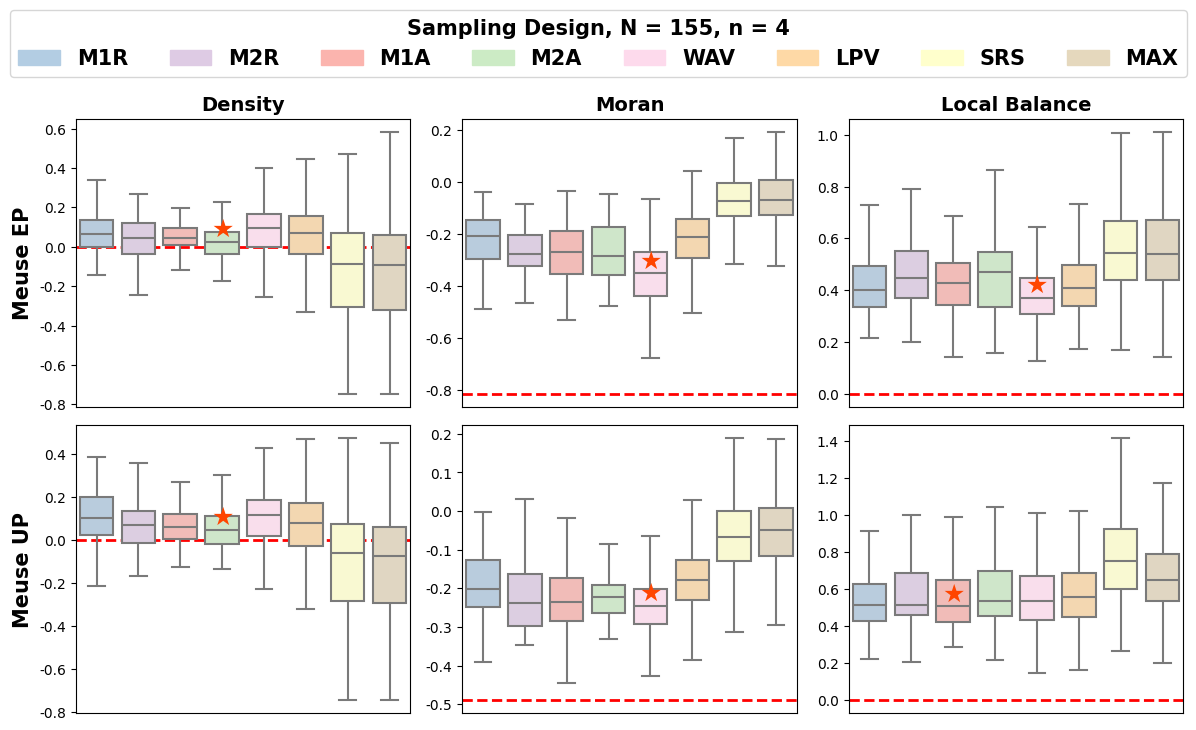

In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

def find_closest_method(filtered, metric, dashed_line_value):
    """
    Find method whose median is closest to the dashed_line_value using ONLY filtered (plotted) data.
    Returns (best_method, best_median) or (None, None) if no methods have data.
    """
    methods_with_data = filtered.groupby('Method')[metric].count()
    present_methods = methods_with_data[methods_with_data > 0].index
    if len(present_methods) == 0:
        return None, None
    medians = filtered.groupby('Method')[metric].median()
    closest_method = (medians - dashed_line_value).abs().idxmin()
    return closest_method, medians[closest_method]

# Folder and file info
method_order = ["M1R", "M2R", "M1A", "M2A", "WAV", "LPV", "SRS", "MAX"]
results_folder = 'data_samples/results'
result_files = [
    "results_meuse_eq.csv",
    "results_meuse_uneq.csv",
]
pretty_names = {
    "meuse_eq": "Meuse EP",
    "meuse_uneq": "Meuse UP",
}

pop_names = [s.replace("results_", "").replace(".csv", "") for s in result_files]

# Read results into a dict
results_dict = {
    name: pd.read_csv(os.path.join(results_folder, fname))
    for name, fname in zip(pop_names, result_files)
}
method_name_mapping = {
    "K-Means (11_random)":   "M1R",
    "K-Means (22_random)":   "M2R",
    "K-Means (11_lexico)":   "M1A",
    "K-Means (22_lexico)":   "M2A",
    "Wave": "WAV",
    "Local Pivotal": "LPV",
    "Random": "SRS",
    "UPmaxentropy": "MAX"
}
for df in results_dict.values():
    df["Method"] = df["Method"].map(method_name_mapping)
for df in results_dict.values():
    if "Method Pretty" in df.columns:
        df.drop(columns=["Method Pretty"], inplace=True)
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel1", n_colors=len(all_methods))))
columns = [c for c in results_dict[pop_names[0]].columns if c != "Method"]

n_rows = len(pop_names)
n_cols = len(columns)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]

        # Optional: Filtering (uncomment and tune if you use)
        # filtered = df_pop[df_pop[metric] < 2]
        filtered = df_pop.copy()

        # Dashed line logic
        if metric in ['Density', 'Local Balance']:
            dashed_line_value = 0
        else:
            dashed_line_value = filtered['Moran'].min()
        ax.axhline(y=dashed_line_value, color='red', linestyle='--', linewidth=2)

        # Plot boxplot
        sns.boxplot(
            x="Method",
            y=metric,
            data=filtered,
            hue="Method",
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5
        )
        legend = ax.get_legend()
        if legend: legend.remove()
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=15)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.tick_params(axis='x', length=0)
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))  # 1 decimal

        # --------- Robust star annotation logic ---------
        best_method, best_median = find_closest_method(filtered, metric, dashed_line_value)
        if best_method is not None and best_method in method_order:
            x_pos = method_order.index(best_method)
            method_data = filtered[filtered["Method"] == best_method][metric].dropna()
            if len(method_data) > 0:
                box_max = method_data.max()
                ylim = ax.get_ylim()
                y_offset = 0.07 * (ylim[1] - ylim[0])
                star_y = box_max + y_offset
                star_y = best_median
                ax.annotate(
                    "★", (x_pos, star_y),
                    ha="center", va="bottom",
                    fontsize=18, color="orangered", fontweight="bold"
                )
        # If no suitable box for star, silently skip

# ----------- SHARED LEGEND BLOCK -----------
fig_legend, ax_legend = plt.subplots()
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)

sns.boxplot(
    x="Method",
    y=columns[0],
    data=df_concat,
    palette=method_palette,
    ax=ax_legend,
    showfliers=False
)
handles, labels = ax_legend.get_legend_handles_labels()
if all([h is None for h in handles]) or not handles:
    labels = [t.get_text() for t in ax_legend.get_xticklabels()]
    from matplotlib.patches import Patch
    handles = [Patch(color=method_palette[l]) for l in labels]
label_to_handle = dict(zip(labels, handles))
final_labels = [m for m in method_order if m in label_to_handle]
final_handles = [label_to_handle[m] for m in final_labels]
plt.close(fig_legend)
leg = fig.legend(
    final_handles, final_labels,
    loc='upper center',
    ncol=len(final_labels),
    title="Sampling Design, N = 155, n = 4",
    fontsize=15,
    title_fontsize=15
)
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')

fig.tight_layout(rect=[0, 0.08, 1, 1])
fig.subplots_adjust(top=0.85)
plt.show()

# Store


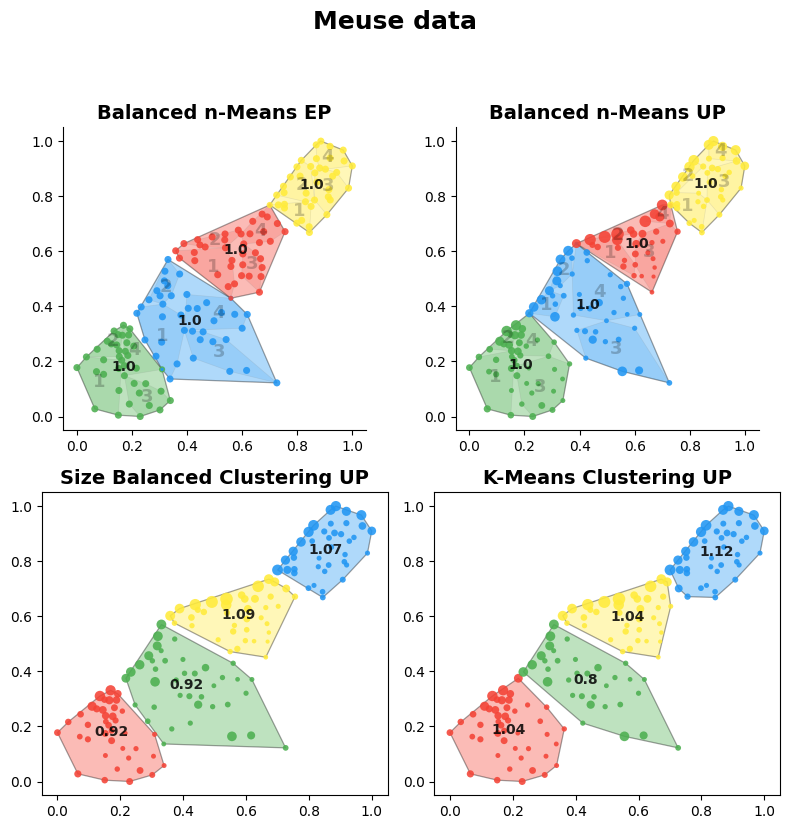

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull, QhullError
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained

# ---- COLOURS ----
bardi_colors = [
    "#F44336", "#4CAF50", "#FFEB3B", "#2196F3",
    "#FF9800", "#9C27B0", "#E91E63", "#00BCD4",
    "#BDBDBD", "#FFD700"
]
row_labels = [
    "Balanced n-Means EP",
    "Balanced n-Means UP",
    "Size Balanced Clustering UP",
    "K-Means Clustering UP",
]

def get_sorted_cluster_indices_by_lexico_centroids(centroids):
    sorted_order = np.lexsort((centroids[:, 0], centroids[:, 1]))
    label_to_color = np.zeros_like(sorted_order)
    for color_idx, label in enumerate(sorted_order):
        label_to_color[label] = color_idx
    return label_to_color, centroids[sorted_order]

def plot_convex_hull(points, ax, color, alpha=0.33, edge_color="gray", line_width=0.6):
    """Plot convex hull safely. Always returns (ax, hull or None)."""
    if len(points) < 3:
        return ax, None
    try:
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
            zorder=1
        )
        ax.add_patch(polygon)
        return ax, hull
    except QhullError:
        # Can't make hull, skip
        return ax, None

# -------- SCALING ---------
SCALING = 1 # adjust if you want

coords_eq = pop_objs['meuse_eq'].coords / SCALING
probs_eq  = pop_objs['meuse_eq'].probs

coords_uneq = pop_objs['meuse_uneq'].coords / SCALING
probs_uneq  = pop_objs['meuse_uneq'].probs

n_clusters = n
colors = bardi_colors[:n_clusters]

# For cluster assignments, use unequal FIP scaled data
X = coords_uneq
probs = probs_uneq

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle("Meuse data", fontsize=18, fontweight='bold', y=1.03)
axes = axes.flatten()

# -- 0 -- Balanced n-Means EP
ax = axes[0]
old_coords = pop_objs['meuse_eq'].coords
pop_objs['meuse_eq'].coords = coords_eq
pop_objs['meuse_eq'].plot_convex_hull = plot_convex_hull
try:
    pop_objs['meuse_eq'].plot(ax=ax)
except Exception as e:
    print(f"Error plotting meuse_eq: {e}")
pop_objs['meuse_eq'].coords = old_coords
ax.set_title(row_labels[0], fontsize=14, fontweight='bold')

# -- 1 -- Balanced n-Means UP
ax = axes[1]
old_coords = pop_objs['meuse_uneq'].coords
pop_objs['meuse_uneq'].coords = coords_uneq
pop_objs['meuse_uneq'].plot_convex_hull = plot_convex_hull
try:
    pop_objs['meuse_uneq'].plot(ax=ax)
except Exception as e:
    print(f"Error plotting meuse_uneq: {e}")
pop_objs['meuse_uneq'].coords = old_coords
ax.set_title(row_labels[1], fontsize=14, fontweight='bold')

# -- 2 -- Size Balanced Clustering UP
ax = axes[2]
kmeans_const = KMeansConstrained(
    n_clusters=n_clusters,
    size_min=int(X.shape[0] / n_clusters),
    size_max=int(np.ceil(X.shape[0] / n_clusters)),
    random_state=1
).fit(X)
const_labels = kmeans_const.labels_
const_centroids = np.array([
    X[const_labels == i].mean(axis=0) if np.any(const_labels == i) else np.array([np.nan, np.nan])
    for i in range(n_clusters)
])
const_label_to_color, _ = get_sorted_cluster_indices_by_lexico_centroids(const_centroids)
const_remapped = const_label_to_color[const_labels]
for color_idx in range(n_clusters):
    idx = (const_remapped == color_idx)
    cluster_points = X[idx]
    cluster_color = colors[color_idx]
    if np.sum(idx) >= 3:
        _, hull = plot_convex_hull(cluster_points, ax,
                                   color=cluster_color, alpha=0.36, edge_color='black', line_width=0.9)
    ax.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        color=cluster_color, edgecolors="none",
        s=probs[idx]*1000, alpha=0.88, zorder=2,
    )
    prob_sum = round(probs[idx].sum(), 2) if np.any(idx) else 0
    center = cluster_points.mean(axis=0) if len(cluster_points) > 0 else np.array([np.nan, np.nan])
    ax.text(center[0], center[1], f"{prob_sum}",
            color="black", fontsize=10, weight="bold", alpha=0.85,
            ha="center", va="center", zorder=3)
ax.set_title(row_labels[2], fontsize=14, fontweight='bold')

# -- 3 -- Standard KMeans Clustering UP
ax = axes[3]
kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(X)
kmeans_labels = kmeans.labels_
kmeans_centroids = np.array([
    X[kmeans_labels == i].mean(axis=0) if np.any(kmeans_labels == i) else np.array([np.nan, np.nan])
    for i in range(n_clusters)
])
kmeans_label_to_color, _ = get_sorted_cluster_indices_by_lexico_centroids(kmeans_centroids)
kmeans_remapped = kmeans_label_to_color[kmeans.labels_]
for color_idx in range(n_clusters):
    idx = (kmeans_remapped == color_idx)
    cluster_points = X[idx]
    cluster_color = colors[color_idx]
    if np.sum(idx) >= 3:
        _, hull = plot_convex_hull(cluster_points, ax,
                                   color=cluster_color, alpha=0.36, edge_color='black', line_width=0.9)
    ax.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        color=cluster_color, edgecolors="none",
        s=probs[idx]*1000, alpha=0.88, zorder=2,
    )
    prob_sum = round(probs[idx].sum(), 2) if np.any(idx) else 0
    center = cluster_points.mean(axis=0) if len(cluster_points) > 0 else np.array([np.nan, np.nan])
    ax.text(center[0], center[1], f"{prob_sum}",
            color="black", fontsize=10, weight="bold", alpha=0.85,
            ha="center", va="center", zorder=3)
ax.set_title(row_labels[3], fontsize=14, fontweight='bold')

# --------- SAFE FORMATTING: BASED ON X DATA, NOT [0,1]! ---------
for ax in axes:
    ax.autoscale()
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

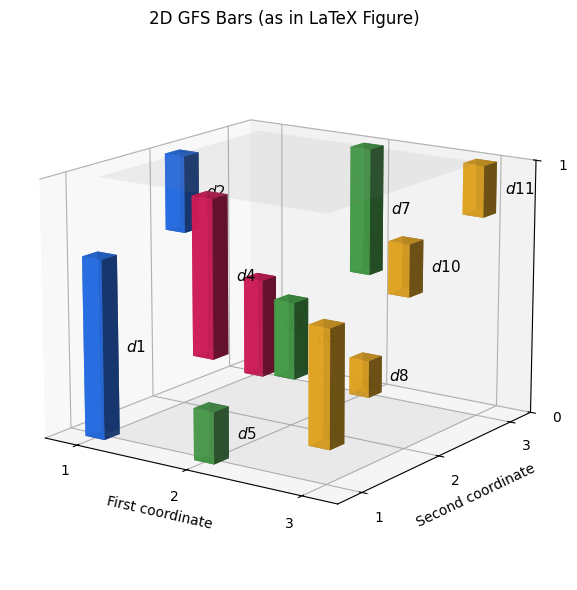

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

bars_3d = [
    # x, y, z_start, z_end, label, color
    (1, 1, 0.0, 0.7, 'd1', 'myblue'),
    (1, 2, 0.7, 1.0, 'd2', 'myblue'),
    (1, 3, 0.0, 0.4, 'd3', 'myred'),
    (2, 1, 0.4, 1.0, 'd4', 'myred'),
    (2, 1, 0.0, 0.2, 'd5', 'mygreen'),
    (2, 2, 0.2, 0.5, 'd6', 'mygreen'),
    (2, 3, 0.5, 1.0, 'd7', 'mygreen'),
    (2, 3, 0.0, 0.15, 'd8', 'mygold'),
    (3, 1, 0.15, 0.6, 'd9', 'mygold'),
    (3, 2, 0.6, 0.8, 'd10', 'mygold'),
    (3, 3, 0.8, 1.0, 'd11', 'mygold'),
]

color_dict = {
    "myblue": "#2979FF",
    "myred": "#E91E63",
    "mygreen": "#4CAF50",
    "mygold": "#FDB827",
    "mypurple": "#9C27B0",
}

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111, projection='3d')

dx = dy = 0.18  # bar thickness

for (x, y, z1, z2, label, cgroup) in bars_3d:
    height = z2 - z1
    ax.bar3d(x - dx/2, y - dy/2, z1, dx, dy, height, color=color_dict[cgroup], alpha=0.85)
    ax.text(x + dx/2 + 0.07, y + dy/2, (z1+z2)/2, f"${label}$", fontsize=11, va='center', ha='left')

# Draw "floors" at z=0 and z=1
for z, alpha in [(0, 0.1), (1, 0.1)]:
    X, Y = np.meshgrid([1,2,3], [1,2,3])
    Z = np.full_like(X, z)
    ax.plot_surface(X, Y, Z, color='gray', alpha=alpha, shade=False)

ax.set_xlim(0.7,3.3)
ax.set_ylim(0.7,3.3)
ax.set_zlim(0,1)
ax.set_xlabel("First coordinate")
ax.set_ylabel("Second coordinate")
ax.set_zlabel("Inclusion Probabilities")
ax.set_xticks([1,2,3])
ax.set_yticks([1,2,3])
ax.set_zticks([0,1])
ax.view_init(elev=15, azim=-55)
ax.set_title("2D GFS Bars (as in LaTeX Figure)")

plt.tight_layout()
plt.show()

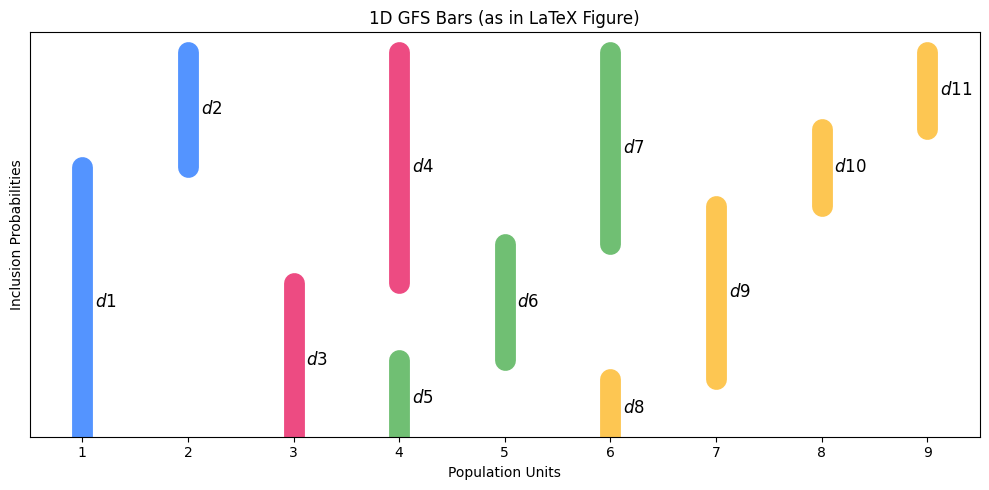

In [29]:
import matplotlib.pyplot as plt

# Coordinates for each bar segment: (x, y_start, y_end, label)
bars = [
    (1, 0.0, 0.7, 'd1', 'myblue'),
    (2, 0.7, 1.0, 'd2', 'myblue'),
    (3, 0.0, 0.4, 'd3', 'myred'),
    (4, 0.4, 1.0, 'd4', 'myred'),
    (4, 0.0, 0.2, 'd5', 'mygreen'),
    (5, 0.2, 0.5, 'd6', 'mygreen'),
    (6, 0.5, 1.0, 'd7', 'mygreen'),
    (6, 0.0, 0.15, 'd8', 'mygold'),
    (7, 0.15, 0.6, 'd9', 'mygold'),
    (8, 0.6, 0.8, 'd10', 'mygold'),
    (9, 0.8, 1.0, 'd11', 'mygold'),
]

color_dict = {
    "myblue": "#2979FF",
    "myred": "#E91E63",
    "mygreen": "#4CAF50",
    "mygold": "#FDB827",
    "mypurple": "#9C27B0",
}

fig, ax = plt.subplots(figsize=(10, 5))

for (x, y1, y2, label, cgroup) in bars:
    ax.plot([x, x], [y1, y2], color=color_dict[cgroup], lw=15, alpha=0.8, solid_capstyle='round')
    ax.text(x+0.12, (y1+y2)/2, f"${label}$", va='center', fontsize=12)

ax.set_xlim(0.5, 9.5)
ax.set_ylim(0, 1.05)
ax.set_xticks(range(1, 10))
ax.set_yticks([])
ax.set_xlabel("Population Units")
ax.set_ylabel("Inclusion Probabilities")
ax.grid(axis='y', linestyle='dashed', alpha=0.5)
ax.set_title("1D GFS Bars (as in LaTeX Figure)")

plt.tight_layout()
plt.show()

                   Method   Density     Moran  Local Balance
0      K-Means (22_sort_)  0.057113 -0.213775       0.254765
1      K-Means (22_sort_) -0.722887 -0.095892       0.668408
2      K-Means (22_sort_)  0.061921 -0.256909       0.391565
3      K-Means (22_sort_) -0.260693 -0.101375       0.547896
4      K-Means (22_sort_) -0.527703 -0.028752       0.739708
...                   ...       ...       ...            ...
20696    K-Means (33rand)  0.013924 -0.176225       0.306510
20697    K-Means (33rand) -0.001555 -0.170339       0.237261
20698    K-Means (33rand)  0.100144 -0.258505       0.487673
20699    K-Means (33rand)  0.188438 -0.113590       1.489019
20700    K-Means (33rand) -0.014436 -0.207364       0.209792

[20701 rows x 4 columns]


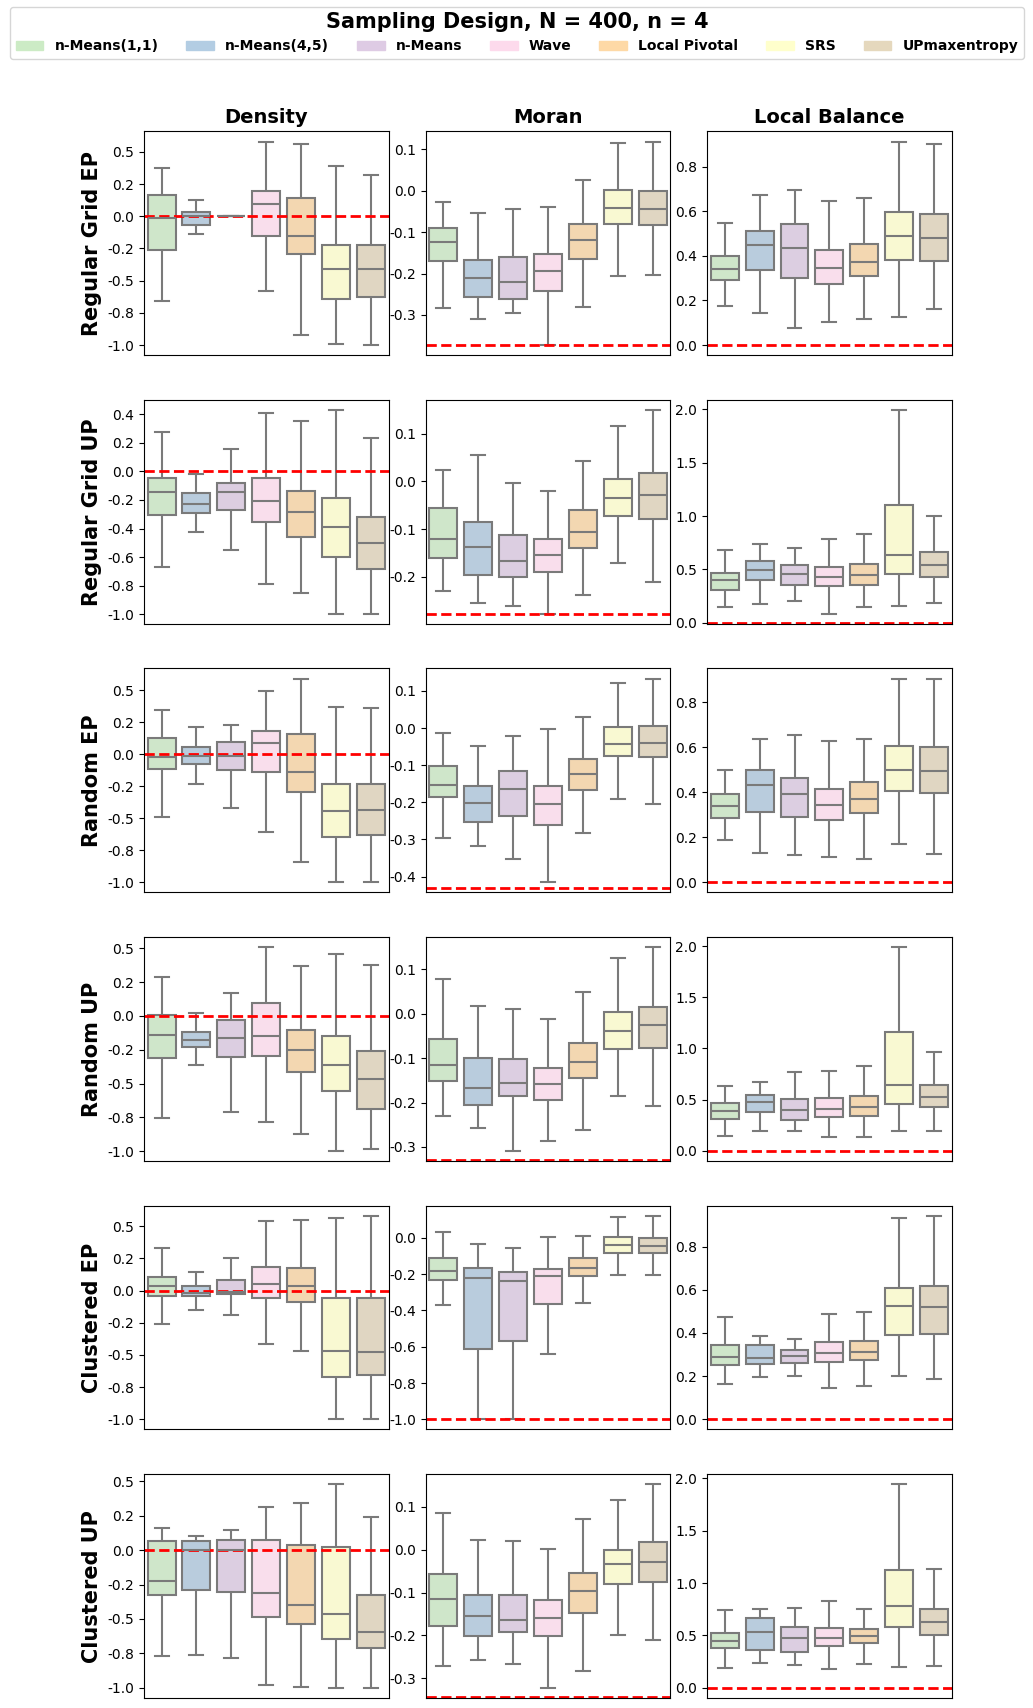

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

# Folder and file info
method_order = ["n-Means(1,1)", "n-Means(11)2", "origin", "mahatan", "project", "Local Pivotal", "Wave", "SRS", "UPmaxentropy"]
method_order = ["n-Means(1,1)", "n-Means(4,5)", 'n-Means', "Wave", "Local Pivotal",  "SRS", "UPmaxentropy"]
results_folder = 'data_samples/results'
result_files = [
    "results_grid_eq.csv",
    "results_grid_uneq.csv",
    "results_random_eq.csv",
    "results_random_uneq.csv",
    "results_clust_eq.csv",
    "results_clust_uneq.csv",
    # "results_swiss_eq_n=10.csv",
    # "results_swiss_uneq_n=10.csv",
]
pretty_names = {
    "grid_eq": "Regular Grid Equal FIP",
    "grid_uneq": "Regular Grid Unequal FIP",
    "random_eq": "Random Equal FIP",
    "random_uneq": "Random Unequal FIP",
    "clust_eq": "Clustered Equal FIP",
    "clust_uneq": "Clustered Unequal FIP",
}

pretty_names = {
    "grid_eq": "Regular Grid EP",
    "grid_uneq": "Regular Grid UP",
    "random_eq": "Random EP",
    "random_uneq": "Random UP",
    "clust_eq": "Clustered EP",
    "clust_uneq": "Clustered UP",
}

# Use the new column for plotting (x or hue):
pop_names = [s.replace("results_", "").replace(".csv", "") for s in result_files]

# Read results into a dict
colnames = ["Method", "Density", "Moran", "Voronoi"]
results_dict = {}
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname))#names=colnames, header=True)
    results_dict[name] = df
print(df)
# Mapping for nicer method names
method_name_mapping = {
    #"K-Means (11_lexsort)": "n-Means(11)",
    # "K-Means (11_lexsort2)": "n-Means(11)2",
    # "K-Means (11_origin)": "origin",
    # "K-Means (11_mahatan)": "mahatan",
    "K-Means (11_random_)": "n-Means(1,1)",
    "K-Means (45_random_)": "n-Means(4,5)",
    "K-Means (11_lexsortxy)": "n-Means",
    "wave": "Wave",
    "Local Pivotal": "Local Pivotal",
    "Random": "SRS",
    "UPmaxentropy": "UPmaxentropy"
}

# Apply the mapping to ALL dataframes in your results_dict
for df in results_dict.values():
    df["Method"] = df["Method"].map(method_name_mapping)

# OPTIONAL: Remove any 'Method Pretty' columns if you made them previously
for df in results_dict.values():
    if "Method Pretty" in df.columns:
        df.drop(columns=["Method Pretty"], inplace=True)
# Method palette for coloring
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel1", n_colors=len(all_methods))))

# Metrics
columns = [c for c in results_dict[pop_names[0]].columns if c != "Method"]
#columns = [columns[i] for i in [0, 2, 1, 3]]

# Create 6x4 grid (6 populations, 4 metrics)
n_rows = len(pop_names)
n_cols = len(columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]
        sns.boxplot(
            x="Method",
            y=metric,
            data=df_pop[df_pop[metric] < 2],  # <--- Filter here!
#            data=df_pop, #remove_outliers(df_pop, metric, IQR_coef=10, groupby_col="Method"),
            hue="Method",  # always assign hue for consistent handles
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5,
            #boxprops=dict(color='black'),
            #whiskerprops=dict(color='black'),
            #capprops=dict(color='black'),
            #medianprops=dict(color='black'),
        )
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
        ax.tick_params(axis='x', length=0)  # This removes the little black lines (ticks) on the x-axis
        #ax.grid(True)
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=15)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        if not (row_idx == 0 and col_idx == 0):
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))  # 2 decimals
        if metric in ['Density', 'Voronoi', 'Local Balance']:
            ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
        else:
            ax.axhline(y=min(df_pop['Moran']), color='red', linestyle='--', linewidth=2)
# ... rest of your code as above ...

# ----------- SHARED LEGEND BLOCK (robust dummy plot method) -----------
fig_legend, ax_legend = plt.subplots()
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)

# NOTE: Only use x="Method", NOT hue!
sns.boxplot(
    x="Method",
    y=columns[0],
    data=df_concat,
    palette=method_palette,
    ax=ax_legend,
    showfliers=False
)

from matplotlib.patches import Patch
labels = method_order
handles = [Patch(color=method_palette[l]) for l in labels]
plt.close(fig_legend)
leg = fig.legend(
    handles, labels, loc='upper center', ncol=len(all_methods),
    title="Sampling Design, N = 400, n = 4",
    fontsize=10,              # Label size
    title_fontsize=15         # Title size
    # No fontweight argument directly here
)

# Make legend labels bold
for text in leg.get_texts():
    text.set_fontweight('bold')

# Make legend title bold
leg.get_title().set_fontweight('bold')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(wspace=0.15, hspace=0.2)
# fig.suptitle("All metrics for all populations", fontsize=16, y=1.01)
plt.show()